# Install Necessary Libraries

In [1]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Configuration and Optimization (For Realistic Mode)

In [3]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import(
precision_recall_curve , recall_score , f1_score , balanced_accuracy_score ,
roc_auc_score , confusion_matrix , precision_score , classification_report ,
matthews_corrcoef , cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score , classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler


# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "realistic"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak']  = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)



X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

def objective(trial):
    # SMOTE parameters
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

    # SVC parameters
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    max_iter = trial.suggest_int('max_iter', 1000, 5000)

    clf = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        max_iter=max_iter,
        probability=False,
        random_state=SEED
    )

    pipe = ImbPipeline([
        ("smote", smote),
        ('scaler', StandardScaler()),
        ("clf", clf)
    ])

    pipe.fit(X_train, y_train) # Trains the pipeline on the training set.
    y_val_pred = pipe.predict(X_val) # Predicts on the validation set. evaluating the model trained on the training set.
    return balanced_accuracy_score(y_val, y_val_pred)

# ==============================================================================
# RUN OPTUNA STUDY
# ==============================================================================

study = optuna.create_study(direction = "maximize" , study_name = "SVC_Realistic")
study.optimize(objective , n_trials = N_TRIALS , show_progress_bar = True)

best_params = study.best_params
print("\nBest Hyperparameters",best_params)

# ==============================================================================
# FINAL MODEL TRAINING
# ==============================================================================

best_params_svm = study.best_params
smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[best_params_svm['smote_level']]
best_smote_svm = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

svm_clf = SVC(
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma'],
    max_iter=best_params_svm['max_iter'],
    probability=True,
    random_state=SEED
)

final_pipe_svm = ImbPipeline([
    ("smote", best_smote_svm),
    ("scaler", StandardScaler()),
    ("clf", svm_clf)
])
# Trains on both the training and validation sets combined
# since the model is finalized, we now want it to learn from all available labeled data before testing.
final_pipe_svm.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Reading file...


[I 2025-12-08 19:29:33,112] A new study created in memory with name: SVC_Realistic


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=realistic -> Dropped CA and PA

Features: 65  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3359).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:29:47,631] Trial 0 finished with value: 0.48641095758971403 and parameters: {'smote_level': 'small', 'C': 0.0016304565683833217, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3359}. Best is trial 0 with value: 0.48641095758971403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3109).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:30:13,012] Trial 1 finished with value: 0.6943212348005094 and parameters: {'smote_level': 'high', 'C': 2.374744499738705, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3109}. Best is trial 1 with value: 0.6943212348005094.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3729).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:30:30,249] Trial 2 finished with value: 0.6165432389525654 and parameters: {'smote_level': 'high', 'C': 2.8003739744048444, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3729}. Best is trial 1 with value: 0.6943212348005094.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1737).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:30:38,521] Trial 3 finished with value: 0.6455967272029448 and parameters: {'smote_level': 'high', 'C': 48.640713444061156, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1737}. Best is trial 1 with value: 0.6943212348005094.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3603).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:31:12,215] Trial 4 finished with value: 0.7242949791524922 and parameters: {'smote_level': 'high', 'C': 1.1244095837934343, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3603}. Best is trial 4 with value: 0.7242949791524922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2968).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:31:21,691] Trial 5 finished with value: 0.7052258334641754 and parameters: {'smote_level': 'small', 'C': 0.06480469531024313, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2968}. Best is trial 4 with value: 0.7242949791524922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2818).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:31:35,141] Trial 6 finished with value: 0.5326854468693847 and parameters: {'smote_level': 'high', 'C': 57.26141846506825, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2818}. Best is trial 4 with value: 0.7242949791524922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3018).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:31:53,836] Trial 7 finished with value: 0.6223929711624012 and parameters: {'smote_level': 'small', 'C': 0.0012613088250156084, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3018}. Best is trial 4 with value: 0.7242949791524922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1314).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:31:57,295] Trial 8 finished with value: 0.47700559131906284 and parameters: {'smote_level': 'small', 'C': 953.5711165545038, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1314}. Best is trial 4 with value: 0.7242949791524922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4517).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:32:07,306] Trial 9 finished with value: 0.6373460424626227 and parameters: {'smote_level': 'small', 'C': 9.02975684063278, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4517}. Best is trial 4 with value: 0.7242949791524922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4903).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:32:45,011] Trial 10 finished with value: 0.7605404214860174 and parameters: {'smote_level': 'medium', 'C': 0.12279944589800988, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4903}. Best is trial 10 with value: 0.7605404214860174.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4936).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:33:23,918] Trial 11 finished with value: 0.7859183370841403 and parameters: {'smote_level': 'medium', 'C': 0.06967563721348727, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4936}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4947).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:34:01,496] Trial 12 finished with value: 0.7772086146438477 and parameters: {'smote_level': 'medium', 'C': 0.09032002660356046, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4947}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4274).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:34:34,216] Trial 13 finished with value: 0.7722616929223147 and parameters: {'smote_level': 'medium', 'C': 0.0333206050222794, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4274}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4931).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:35:13,956] Trial 14 finished with value: 0.5906768461820275 and parameters: {'smote_level': 'medium', 'C': 0.00940546270077975, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4931}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4176).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:35:45,027] Trial 15 finished with value: 0.7602242197449451 and parameters: {'smote_level': 'medium', 'C': 0.1870776669041409, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4176}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2284).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:36:01,431] Trial 16 finished with value: 0.5898917935835034 and parameters: {'smote_level': 'medium', 'C': 0.013110725581635355, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 2284}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3972).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:36:30,133] Trial 17 finished with value: 0.7420240836691614 and parameters: {'smote_level': 'medium', 'C': 0.2522314837383346, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3972}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4562).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:37:07,049] Trial 18 finished with value: 0.5774094572669702 and parameters: {'smote_level': 'medium', 'C': 0.009966556402330153, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4562}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2344).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:37:24,242] Trial 19 finished with value: 0.7575932031890581 and parameters: {'smote_level': 'medium', 'C': 0.4118822055985857, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 2344}. Best is trial 11 with value: 0.7859183370841403.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4618).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:37:59,759] Trial 20 finished with value: 0.8147243156958183 and parameters: {'smote_level': 'medium', 'C': 0.034819043095359464, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4618}. Best is trial 20 with value: 0.8147243156958183.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4992).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:38:40,436] Trial 21 finished with value: 0.813311221018475 and parameters: {'smote_level': 'medium', 'C': 0.02796217179621721, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4992}. Best is trial 20 with value: 0.8147243156958183.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4584).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:39:19,061] Trial 22 finished with value: 0.7531445717974214 and parameters: {'smote_level': 'medium', 'C': 0.02467929422743333, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4584}. Best is trial 20 with value: 0.8147243156958183.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4543).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:39:55,738] Trial 23 finished with value: 0.5668112471868949 and parameters: {'smote_level': 'medium', 'C': 0.0036632391248000357, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4543}. Best is trial 20 with value: 0.8147243156958183.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3935).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:40:26,073] Trial 24 finished with value: 0.5621009315957503 and parameters: {'smote_level': 'medium', 'C': 0.005057434037205317, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3935}. Best is trial 20 with value: 0.8147243156958183.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4304).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:40:59,689] Trial 25 finished with value: 0.726490945726697 and parameters: {'smote_level': 'medium', 'C': 0.4958009734475738, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4304}. Best is trial 20 with value: 0.8147243156958183.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4670).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:41:35,839] Trial 26 finished with value: 0.8207376005303466 and parameters: {'smote_level': 'medium', 'C': 0.04596162012828208, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4670}. Best is trial 26 with value: 0.8207376005303466.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4149).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:42:08,815] Trial 27 finished with value: 0.7299517192651908 and parameters: {'smote_level': 'medium', 'C': 0.02955356498606317, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4149}. Best is trial 26 with value: 0.8207376005303466.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4681).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:42:46,158] Trial 28 finished with value: 0.5738767205736117 and parameters: {'smote_level': 'medium', 'C': 0.0023116385269290793, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4681}. Best is trial 26 with value: 0.8207376005303466.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3414).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:43:12,651] Trial 29 finished with value: 0.6175278257532144 and parameters: {'smote_level': 'medium', 'C': 0.0010494934310928468, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3414}. Best is trial 26 with value: 0.8207376005303466.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3796).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:43:38,459] Trial 30 finished with value: 0.8276057204166012 and parameters: {'smote_level': 'small', 'C': 0.027728114099054565, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3796}. Best is trial 30 with value: 0.8276057204166012.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3952).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:44:03,507] Trial 31 finished with value: 0.8332537377226497 and parameters: {'smote_level': 'small', 'C': 0.0218583670443356, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3952}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3766).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:44:27,747] Trial 32 finished with value: 0.5723829399347534 and parameters: {'smote_level': 'small', 'C': 0.005786633614925694, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3766}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3355).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:44:48,216] Trial 33 finished with value: 0.6275361560335653 and parameters: {'smote_level': 'small', 'C': 0.01704773527523907, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3355}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3939).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:45:13,670] Trial 34 finished with value: 0.7752100015701052 and parameters: {'smote_level': 'small', 'C': 0.04639703998550148, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3939}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3536).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:45:21,366] Trial 35 finished with value: 0.6969882329338288 and parameters: {'smote_level': 'small', 'C': 1.0121187807695278, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3536}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4357).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:45:46,544] Trial 36 finished with value: 0.6707423980740043 and parameters: {'smote_level': 'small', 'C': 0.1526061385899971, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4357}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3220).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:46:00,880] Trial 37 finished with value: 0.6207509028104883 and parameters: {'smote_level': 'high', 'C': 2.7725279953366377, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3220}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3698).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:46:23,888] Trial 38 finished with value: 0.5874177875473212 and parameters: {'smote_level': 'small', 'C': 0.0037660920758636625, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3698}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4722).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:47:01,713] Trial 39 finished with value: 0.6605814186772736 and parameters: {'smote_level': 'high', 'C': 6.010375935031721, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4722}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4045).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:47:10,839] Trial 40 finished with value: 0.6720235603007624 and parameters: {'smote_level': 'small', 'C': 0.6558599752856566, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4045}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4757).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:47:41,659] Trial 41 finished with value: 0.6892990788716178 and parameters: {'smote_level': 'small', 'C': 0.05098769338688023, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4757}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4433).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:48:22,597] Trial 42 finished with value: 0.6249858254391933 and parameters: {'smote_level': 'high', 'C': 0.01851220896542252, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4433}. Best is trial 31 with value: 0.8332537377226497.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4753).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:48:55,177] Trial 43 finished with value: 0.8378452050731844 and parameters: {'smote_level': 'small', 'C': 0.007733493573083612, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4753}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2619).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:49:11,588] Trial 44 finished with value: 0.5925206294377279 and parameters: {'smote_level': 'small', 'C': 0.00720256701371019, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2619}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3804).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:49:35,584] Trial 45 finished with value: 0.738103182079866 and parameters: {'smote_level': 'small', 'C': 0.09220051144541877, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3804}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1107).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:49:40,326] Trial 46 finished with value: 0.46208304984211723 and parameters: {'smote_level': 'small', 'C': 0.0026142954047883374, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 1107}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4749).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:50:00,582] Trial 47 finished with value: 0.6268012595732804 and parameters: {'smote_level': 'small', 'C': 57.70791081032562, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4749}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4146).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:50:24,508] Trial 48 finished with value: 0.6732142234085239 and parameters: {'smote_level': 'small', 'C': 0.25995599400805053, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4146}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4454).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:50:54,824] Trial 49 finished with value: 0.703304635299454 and parameters: {'smote_level': 'small', 'C': 0.05601945803133741, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4454}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4819).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:51:40,831] Trial 50 finished with value: 0.5849077999337067 and parameters: {'smote_level': 'high', 'C': 0.0018357511933125114, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4819}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4962).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:52:20,649] Trial 51 finished with value: 0.6800986985572478 and parameters: {'smote_level': 'medium', 'C': 0.014687290842984905, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4962}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4651).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:52:56,930] Trial 52 finished with value: 0.8098951518640638 and parameters: {'smote_level': 'medium', 'C': 0.031380862295064524, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4651}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4985).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:53:28,806] Trial 53 finished with value: 0.6750580066642242 and parameters: {'smote_level': 'small', 'C': 0.10563884942238128, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4985}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4324).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:54:02,850] Trial 54 finished with value: 0.5909123619615848 and parameters: {'smote_level': 'medium', 'C': 0.01310070501489255, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4324}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4813).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:54:41,356] Trial 55 finished with value: 0.5774094572669702 and parameters: {'smote_level': 'medium', 'C': 0.009259282467322988, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4813}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2912).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:54:59,710] Trial 56 finished with value: 0.7086004692869978 and parameters: {'smote_level': 'small', 'C': 0.038242910112266874, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 2912}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4514).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:55:14,974] Trial 57 finished with value: 0.5449573454754801 and parameters: {'smote_level': 'medium', 'C': 696.4257197960598, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4514}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4225).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:55:48,242] Trial 58 finished with value: 0.6991373144222885 and parameters: {'smote_level': 'medium', 'C': 0.025208453566632642, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4225}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1683).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:55:58,134] Trial 59 finished with value: 0.5864375621499973 and parameters: {'smote_level': 'small', 'C': 0.06166039194886219, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 1683}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4064).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:56:30,618] Trial 60 finished with value: 0.5555849950280002 and parameters: {'smote_level': 'medium', 'C': 0.005342801950392189, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4064}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4643).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:57:05,848] Trial 61 finished with value: 0.7913722719422202 and parameters: {'smote_level': 'medium', 'C': 0.02853182867183445, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4643}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4658).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:57:42,336] Trial 62 finished with value: 0.7457901554404145 and parameters: {'smote_level': 'medium', 'C': 0.19989448589513595, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4658}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4406).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:58:17,887] Trial 63 finished with value: 0.6585882573576873 and parameters: {'smote_level': 'medium', 'C': 0.018743831347379124, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4406}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4847).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:58:57,943] Trial 64 finished with value: 0.59075535144188 and parameters: {'smote_level': 'medium', 'C': 0.00976054701202081, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4847}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4561).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 19:59:32,506] Trial 65 finished with value: 0.7822264091694143 and parameters: {'smote_level': 'medium', 'C': 0.09333387976200919, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4561}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4869).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:00:10,860] Trial 66 finished with value: 0.8235594284817083 and parameters: {'smote_level': 'medium', 'C': 0.03528405796095451, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4869}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4990).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:01:03,940] Trial 67 finished with value: 0.5590392264615063 and parameters: {'smote_level': 'high', 'C': 0.003508592828109708, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4990}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3529).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:01:28,018] Trial 68 finished with value: 0.6938502032413949 and parameters: {'smote_level': 'medium', 'C': 1.5990462779654577, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3529}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4854).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:01:40,493] Trial 69 finished with value: 0.6065610770921652 and parameters: {'smote_level': 'small', 'C': 0.29952730186201826, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4854}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3155).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:02:02,703] Trial 70 finished with value: 0.6718174839936497 and parameters: {'smote_level': 'medium', 'C': 0.043830288946626564, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3155}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4642).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:02:37,866] Trial 71 finished with value: 0.7590706285654472 and parameters: {'smote_level': 'medium', 'C': 0.025086952642924085, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4642}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4766).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:03:14,496] Trial 72 finished with value: 0.6045722771759041 and parameters: {'smote_level': 'medium', 'C': 0.010931312467797506, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4766}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4277).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:03:45,915] Trial 73 finished with value: 0.7542600006978246 and parameters: {'smote_level': 'medium', 'C': 0.15561233566807717, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4277}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4508).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:04:19,870] Trial 74 finished with value: 0.6727192041311212 and parameters: {'smote_level': 'medium', 'C': 0.018764948207270822, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4508}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4895).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:04:56,665] Trial 75 finished with value: 0.7835609985869053 and parameters: {'smote_level': 'medium', 'C': 0.07749496790874538, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4895}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4620).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:05:27,147] Trial 76 finished with value: 0.8193201444496782 and parameters: {'smote_level': 'small', 'C': 0.006689195870988696, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4620}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=2671).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:05:43,287] Trial 77 finished with value: 0.578508530904904 and parameters: {'smote_level': 'small', 'C': 0.006298377562752217, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2671}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4064).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:06:09,631] Trial 78 finished with value: 0.5880839919052354 and parameters: {'smote_level': 'small', 'C': 0.003934534947607644, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4064}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4441).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:06:38,764] Trial 79 finished with value: 0.6280431691701122 and parameters: {'smote_level': 'small', 'C': 0.0017614410750530763, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4441}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3854).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:06:54,991] Trial 80 finished with value: 0.796972313811692 and parameters: {'smote_level': 'small', 'C': 0.007348932607384682, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3854}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4648).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:07:26,882] Trial 81 finished with value: 0.7083649535074406 and parameters: {'smote_level': 'small', 'C': 0.03808590368069186, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4648}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4731).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:07:57,424] Trial 82 finished with value: 0.709659199944174 and parameters: {'smote_level': 'small', 'C': 0.032017168557621434, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4731}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4565).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:08:32,935] Trial 83 finished with value: 0.6955642347481725 and parameters: {'smote_level': 'medium', 'C': 0.019258066972639737, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4565}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4861).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:09:17,389] Trial 84 finished with value: 0.8177544006559551 and parameters: {'smote_level': 'high', 'C': 0.06180895758134366, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4861}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4893).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:10:03,541] Trial 85 finished with value: 0.8186245006193194 and parameters: {'smote_level': 'high', 'C': 0.06591201036337727, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4893}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4836).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:10:48,356] Trial 86 finished with value: 0.7926632473264598 and parameters: {'smote_level': 'high', 'C': 0.12463396362939522, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4836}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3656).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:11:21,789] Trial 87 finished with value: 0.7437261213167949 and parameters: {'smote_level': 'high', 'C': 0.05751398262955429, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3656}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4350).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:12:02,394] Trial 88 finished with value: 0.8162628007187592 and parameters: {'smote_level': 'high', 'C': 0.06710676543793244, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4350}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4152).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:12:41,082] Trial 89 finished with value: 0.8158702744194972 and parameters: {'smote_level': 'high', 'C': 0.07879983360673247, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4152}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4319).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:13:22,444] Trial 90 finished with value: 0.735160325186232 and parameters: {'smote_level': 'high', 'C': 0.6238626370925399, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4319}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4218).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:14:00,232] Trial 91 finished with value: 0.8179877357338496 and parameters: {'smote_level': 'high', 'C': 0.07404073868758314, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4218}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4415).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:14:41,516] Trial 92 finished with value: 0.5813347202595907 and parameters: {'smote_level': 'high', 'C': 0.014214148530763913, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4415}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3980).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:15:15,418] Trial 93 finished with value: 0.8093292597826276 and parameters: {'smote_level': 'high', 'C': 0.12504895960605433, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3980}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4214).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:15:52,597] Trial 94 finished with value: 0.7695521711065753 and parameters: {'smote_level': 'high', 'C': 0.04703846342006978, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4214}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4888).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:16:35,878] Trial 95 finished with value: 0.7648516686729122 and parameters: {'smote_level': 'high', 'C': 0.17753664906970398, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4888}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=3859).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:17:09,814] Trial 96 finished with value: 0.8038546082587534 and parameters: {'smote_level': 'high', 'C': 0.07127406292256419, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3859}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4491).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:17:52,503] Trial 97 finished with value: 0.733706887528131 and parameters: {'smote_level': 'high', 'C': 0.38910405321858565, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4491}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4733).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:18:37,746] Trial 98 finished with value: 0.5621009315957503 and parameters: {'smote_level': 'high', 'C': 0.00807633254809697, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4733}. Best is trial 43 with value: 0.8378452050731844.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4584).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[I 2025-12-08 20:19:21,284] Trial 99 finished with value: 0.5807066781807715 and parameters: {'smote_level': 'high', 'C': 0.011283867353839626, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 4584}. Best is trial 43 with value: 0.8378452050731844.

Best Hyperparameters {'smote_level': 'small', 'C': 0.007733493573083612, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4753}


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=4753).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,copy,True
,with_mean,True
,with_std,True
,C,0.007733493573083612


# Plot The Visualization History for the Optuna Realistic Mode

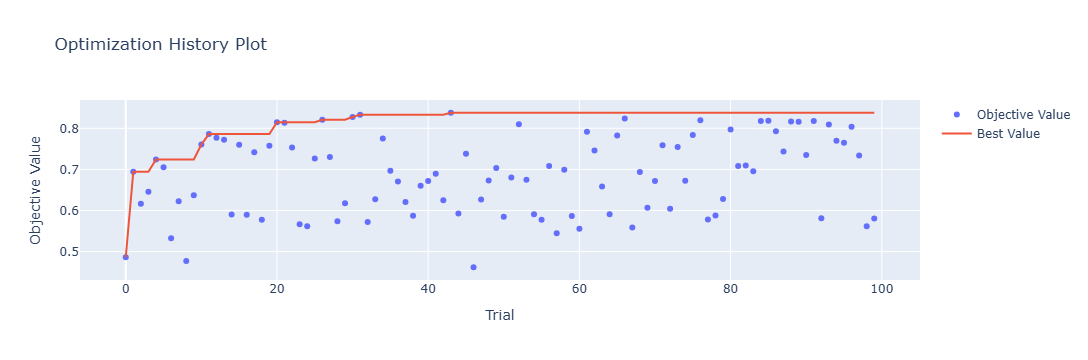

In [4]:
fig1 = optuna.visualization.plot_optimization_history(study)
fig1.write_html("optimization_history_realistic.html")
fig1.show()

# Best Tuned Hyperparamter on Realistic Mode

In [5]:
print(study.best_value)
best_params

0.8378452050731844


{'smote_level': 'small',
 'C': 0.007733493573083612,
 'kernel': 'rbf',
 'gamma': 'scale',
 'max_iter': 4753}

# FINAL EVALUATION ON TEST (with both thresholds) for the Realistic Mode

In [6]:
# ==============================================================================
# FINAL EVALUATION ON TEST
# ==============================================================================

# Predict probabilities
y_test_pred_prop_svc = final_pipe_svm.predict_proba(X_test)[:, 1]


# find thresholds
thresholds_svc = {"F1": None, "Balanced_Accuracy": None}
best_f1_svc = 0
best_bal_svc = 0

for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop_svc >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)
    bal_t = balanced_accuracy_score(y_test, y_pred_t)

    if f1_t > best_f1_svc:
        best_f1_svc = f1_t
        thresholds_svc["F1"] = t
    if bal_t > best_bal_svc:
        best_bal_svc = bal_t
        thresholds_svc["Balanced_Accuracy"] = t

# predictions
y_pred_f1_svc = (y_test_pred_prop_svc >= thresholds_svc["F1"]).astype(int)
y_pred_bal_svc = (y_test_pred_prop_svc >= thresholds_svc["Balanced_Accuracy"]).astype(int)

# metrics dicts
metrics_f1_svc = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1_svc),
    "precision": precision_score(y_test, y_pred_f1_svc),
    "recall": recall_score(y_test, y_pred_f1_svc),
    "f1": f1_score(y_test, y_pred_f1_svc),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_svc),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1_svc),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1_svc),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1_svc)
}

metrics_bal_svc = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal_svc),
    "precision": precision_score(y_test, y_pred_bal_svc),
    "recall": recall_score(y_test, y_pred_bal_svc),
    "f1": f1_score(y_test, y_pred_bal_svc),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_svc),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal_svc),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal_svc),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal_svc)
}

# print SVC results
print("\nFINAL EVALUATION ON TEST SET (SVC)")
print("="*70)

print(f"\nUsing F1 Threshold ({thresholds_svc['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1_svc['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1_svc['precision']:.4f}")
print(f"Recall: {metrics_f1_svc['recall']:.4f}")
print(f"F1 Score: {metrics_f1_svc['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1_svc['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1_svc['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1_svc['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1_svc['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1_svc))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1_svc))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1_svc))

print(f"\nUsing Balanced Accuracy Threshold ({thresholds_svc['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal_svc['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal_svc['precision']:.4f}")
print(f"Recall: {metrics_bal_svc['recall']:.4f}")
print(f"F1 Score: {metrics_bal_svc['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal_svc['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal_svc['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal_svc['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal_svc['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_svc))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_svc))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal_svc))

best_params_svc = study.best_params
best_value_svc = study.best_value
study_svc = study

# Save SVC model dict
model_dict_svc = {
    "best_params": best_params_svc,
    "best_value": best_value_svc,
    "thresholds": thresholds_svc,
    "metrics_f1": metrics_f1_svc,
    "metrics_balanced_accuracy": metrics_bal_svc,
    "study": study_svc,
    "model": final_pipe_svm
}

joblib.dump(model_dict_svc, "SVC_realistic_model.pkl")


FINAL EVALUATION ON TEST SET (SVC)

Using F1 Threshold (0.900)
Balanced Accuracy: 0.7443
Precision: 0.0777
Recall: 0.8203
F1 Score: 0.1419
ROC-AUC: 0.7833
Geometric Mean: 0.7404
Matthews Corr: 0.1831
Cohen Kappa: 0.0870

Confusion Matrix:
 [[4256 2113]
 [  39  178]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80      6369
           1       0.08      0.82      0.14       217

    accuracy                           0.67      6586
   macro avg       0.53      0.74      0.47      6586
weighted avg       0.96      0.67      0.78      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.99      0.67      0.82      0.80      0.74      0.54      6369
          1       0.08      0.82      0.67      0.14      0.74      0.56       217

avg / total       0.96      0.67      0.82      0.78      0.74      0.54      6586


Using Balanced Accuracy

['SVC_realistic_model.pkl']

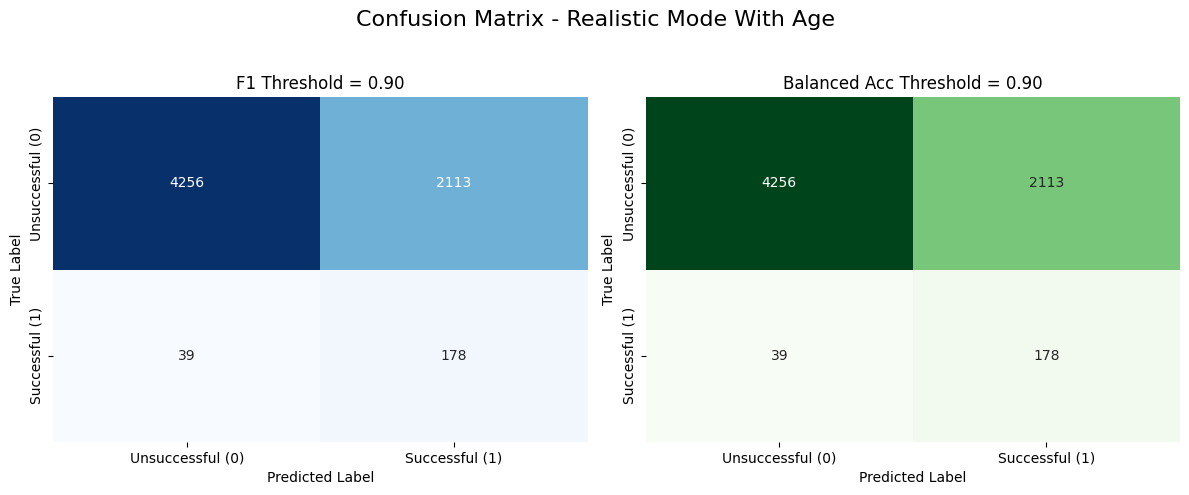

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1_svc)
cm_bal = confusion_matrix(y_test, y_pred_bal_svc)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# F1 Threshold
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds_svc['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# Balanced Accuracy Threshold
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds_svc['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Realistic Mode With Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("Confusion Matrix - Realistic Mode")
plt.show()

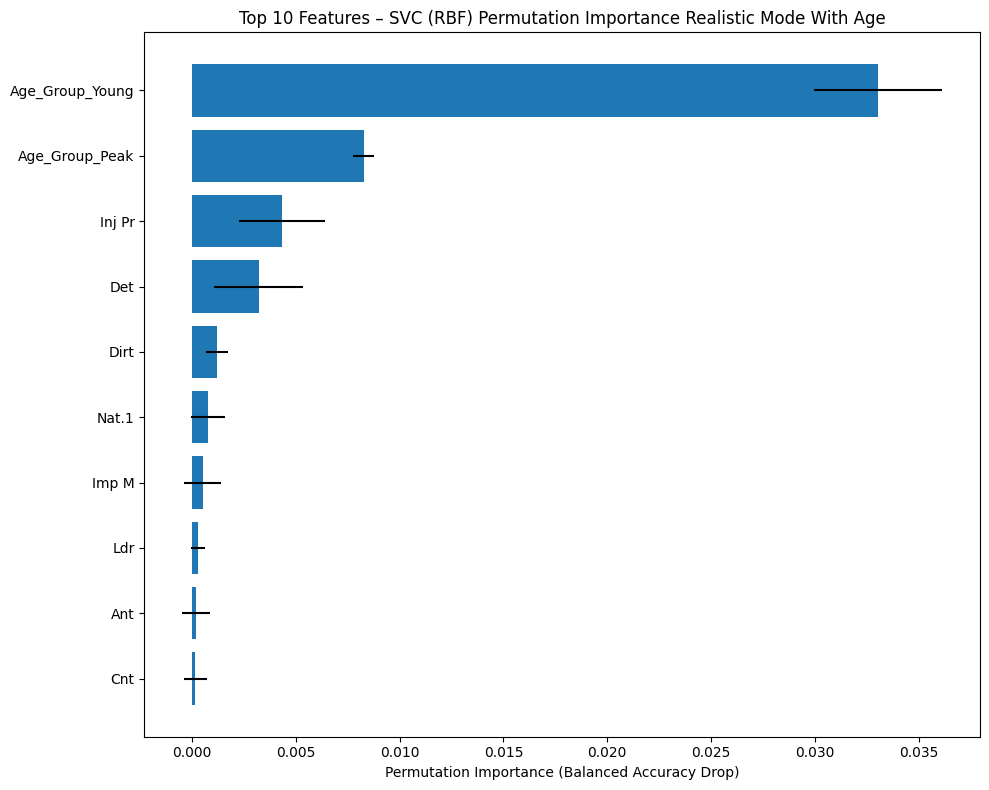

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

result = permutation_importance(
    final_pipe_svm,
    X_test,
    y_test,
    scoring="balanced_accuracy",
    n_repeats=5,
    random_state=SEED,
    n_jobs=-1
)

importances = result.importances_mean
std = result.importances_std
feature_names = np.array(X_test.columns)

# Sort importances
sorted_idx = np.argsort(importances)[::-1]

# Top N features
top_n = 10
top_idx = sorted_idx[:top_n]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_names[top_idx][::-1], importances[top_idx][::-1], xerr=std[top_idx][::-1])
plt.xlabel("Permutation Importance (Balanced Accuracy Drop)")
plt.title("Top 10 Features – SVC (RBF) Permutation Importance Realistic Mode With Age")
plt.tight_layout()
plt.show()

# Data Configuration and Optimization (For Full Mode)

In [10]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import(
precision_recall_curve , recall_score , f1_score , balanced_accuracy_score ,
roc_auc_score , confusion_matrix , precision_score , classification_report ,
matthews_corrcoef , cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import geometric_mean_score , classification_report_imbalanced
import joblib
import optuna
from optuna.samplers import TPESampler


# ==============================================================================
# CONFIGURATION
# ==============================================================================
MODE = "full"       # "realistic" drops CA/PA, "full" keeps them
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"
N_TRIALS = 100


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# drop CA/PA if realistic
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak']  = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)


X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

def objective(trial):
    # SMOTE parameters
    smote_level = trial.suggest_categorical("smote_level", ["small", "medium", "high"])
    smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[smote_level]
    smote = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

    # SVC parameters
    C = trial.suggest_float('C', 1e-3, 1e3, log=True)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
    max_iter = trial.suggest_int('max_iter', 1000, 5000)

    clf = SVC(
        C=C,
        kernel=kernel,
        gamma=gamma,
        max_iter=max_iter,
        probability=False,
        random_state=SEED
    )

    pipe = ImbPipeline([
        ("smote", smote),
        ('scaler', StandardScaler()),
        ("clf", clf)
    ])

    pipe.fit(X_train, y_train) # Trains the pipeline on the training set.
    y_val_pred = pipe.predict(X_val) # Predicts on the validation set. evaluating the model trained on the training set.
    return balanced_accuracy_score(y_val, y_val_pred)

# ==============================================================================
# RUN OPTUNA STUDY
# ==============================================================================

study = optuna.create_study(direction = "maximize" , study_name = "SVC_Full")
study.optimize(objective , n_trials = N_TRIALS , show_progress_bar = True)

best_params = study.best_params
print("\nBest Hyperparameters",best_params)

# ==============================================================================
# FINAL MODEL TRAINING
# ==============================================================================

best_params_svm = study.best_params
smote_ratio = {"small": 0.2, "medium": 0.5, "high": 1.0}[best_params_svm['smote_level']]
best_smote_svm = SMOTE(sampling_strategy=smote_ratio, random_state=SEED)

svm_clf = SVC(
    C=best_params_svm['C'],
    kernel=best_params_svm['kernel'],
    gamma=best_params_svm['gamma'],
    max_iter=best_params_svm['max_iter'],
    probability=True,
    random_state=SEED
)

final_pipe_svm = ImbPipeline([
    ("smote", best_smote_svm),
    ("scaler", StandardScaler()),
    ("clf", svm_clf)
])

# Trains on both the training and validation sets combined
# since the model is finalized, we now want it to learn from all available labeled data before testing.
final_pipe_svm.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

Reading file...


[I 2025-12-08 20:32:43,664] A new study created in memory with name: SVC_Full


Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 69  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


  0%|          | 0/100 [00:00<?, ?it/s]

C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3071).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:33:11,866] Trial 0 finished with value: 0.6976816960625252 and parameters: {'smote_level': 'high', 'C': 0.039458149151865254, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3071}. Best is trial 0 with value: 0.6976816960625252.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1175).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:33:18,293] Trial 1 finished with value: 0.7490950088100348 and parameters: {'smote_level': 'medium', 'C': 0.03617675493080966, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1175}. Best is trial 1 with value: 0.7490950088100348.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4797).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:34:04,966] Trial 2 finished with value: 0.7336730866523613 and parameters: {'smote_level': 'high', 'C': 0.4285679384961881, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4797}. Best is trial 1 with value: 0.7490950088100348.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1506).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:34:12,454] Trial 3 finished with value: 0.5880174805045272 and parameters: {'smote_level': 'high', 'C': 2.382360145693018, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1506}. Best is trial 1 with value: 0.7490950088100348.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3104).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:34:36,929] Trial 4 finished with value: 0.6102628181643726 and parameters: {'smote_level': 'high', 'C': 0.0053906329583901305, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3104}. Best is trial 1 with value: 0.7490950088100348.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3931).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:35:10,755] Trial 5 finished with value: 0.7787329251059821 and parameters: {'smote_level': 'high', 'C': 0.032750958323313796, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3931}. Best is trial 5 with value: 0.7787329251059821.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4413).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:35:19,495] Trial 6 finished with value: 0.7367947610823259 and parameters: {'smote_level': 'small', 'C': 88.25952639970447, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4413}. Best is trial 5 with value: 0.7787329251059821.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1308).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:35:22,808] Trial 7 finished with value: 0.8053233108284922 and parameters: {'smote_level': 'small', 'C': 934.5509523247439, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1308}. Best is trial 7 with value: 0.8053233108284922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3747).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:35:39,495] Trial 8 finished with value: 0.7108029779661904 and parameters: {'smote_level': 'high', 'C': 0.5488542840503564, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3747}. Best is trial 7 with value: 0.8053233108284922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4004).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:35:47,652] Trial 9 finished with value: 0.590040081296558 and parameters: {'smote_level': 'small', 'C': 3.5518917538275003, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4004}. Best is trial 7 with value: 0.8053233108284922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1970).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:35:52,124] Trial 10 finished with value: 0.5028141954955426 and parameters: {'smote_level': 'small', 'C': 893.4914577391082, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1970}. Best is trial 7 with value: 0.8053233108284922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2443).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:36:07,521] Trial 11 finished with value: 0.6544252978838472 and parameters: {'smote_level': 'medium', 'C': 0.0015879754813232527, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 2443}. Best is trial 7 with value: 0.8053233108284922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3599).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:36:20,054] Trial 12 finished with value: 0.6586994731424783 and parameters: {'smote_level': 'small', 'C': 33.95447210560302, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3599}. Best is trial 7 with value: 0.8053233108284922.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2452).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:36:32,985] Trial 13 finished with value: 0.8272960607805168 and parameters: {'smote_level': 'small', 'C': 0.06828673499803464, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2452}. Best is trial 13 with value: 0.8272960607805168.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2302).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:36:41,647] Trial 14 finished with value: 0.6819261265504789 and parameters: {'smote_level': 'small', 'C': 27.552692423104666, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2302}. Best is trial 13 with value: 0.8272960607805168.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1754).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:36:45,732] Trial 15 finished with value: 0.7705498421171997 and parameters: {'smote_level': 'small', 'C': 371.578756119697, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1754}. Best is trial 13 with value: 0.8272960607805168.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2526).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:36:51,946] Trial 16 finished with value: 0.7297129324331397 and parameters: {'smote_level': 'small', 'C': 0.16862582530209627, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2526}. Best is trial 13 with value: 0.8272960607805168.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1508).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:36:58,299] Trial 17 finished with value: 0.68529967202247 and parameters: {'smote_level': 'small', 'C': 6.678640377380236, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1508}. Best is trial 13 with value: 0.8272960607805168.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1083).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:37:05,000] Trial 18 finished with value: 0.6660418956403412 and parameters: {'smote_level': 'medium', 'C': 0.11916552630857677, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1083}. Best is trial 13 with value: 0.8272960607805168.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2765).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:37:15,739] Trial 19 finished with value: 0.8295214668271663 and parameters: {'smote_level': 'small', 'C': 0.006778518339659317, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2765}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2841).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:37:30,882] Trial 20 finished with value: 0.6235302070794299 and parameters: {'smote_level': 'small', 'C': 0.004572809947957161, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2841}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1970).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:37:38,345] Trial 21 finished with value: 0.7684367422061722 and parameters: {'smote_level': 'small', 'C': 0.010002788125545893, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1970}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3384).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:37:46,686] Trial 22 finished with value: 0.7062256851764623 and parameters: {'smote_level': 'small', 'C': 0.13339077942821928, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3384}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2782).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:37:57,854] Trial 23 finished with value: 0.6308900751905934 and parameters: {'smote_level': 'small', 'C': 0.0011797854719321954, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2782}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2092).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:38:05,758] Trial 24 finished with value: 0.8028133232148776 and parameters: {'smote_level': 'small', 'C': 0.010311409990457748, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2092}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1494).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:38:12,485] Trial 25 finished with value: 0.5601361193977774 and parameters: {'smote_level': 'medium', 'C': 0.02303619012141632, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1494}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2631).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:38:18,073] Trial 26 finished with value: 0.38088026203311176 and parameters: {'smote_level': 'small', 'C': 0.8190261567749124, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2631}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3208).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:38:26,814] Trial 27 finished with value: 0.6481383349906666 and parameters: {'smote_level': 'small', 'C': 0.08085787311179664, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3208}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2245).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:38:35,118] Trial 28 finished with value: 0.6646233492088415 and parameters: {'smote_level': 'small', 'C': 13.10376317461327, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2245}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2952).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:38:54,811] Trial 29 finished with value: 0.6268677709739886 and parameters: {'smote_level': 'medium', 'C': 0.003016188707575909, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2952}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1793).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:39:01,702] Trial 30 finished with value: 0.7819669056715688 and parameters: {'smote_level': 'small', 'C': 0.015516435003457112, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1793}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2137).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:39:10,012] Trial 31 finished with value: 0.7955265086094102 and parameters: {'smote_level': 'small', 'C': 0.010563148355240666, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2137}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1261).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:39:14,367] Trial 32 finished with value: 0.6351337206259486 and parameters: {'smote_level': 'small', 'C': 0.055776271645746396, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1261}. Best is trial 19 with value: 0.8295214668271663.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2608).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:39:24,579] Trial 33 finished with value: 0.8299412518972105 and parameters: {'smote_level': 'small', 'C': 0.0027163757304505625, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2608}. Best is trial 33 with value: 0.8299412518972105.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2588).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:39:34,803] Trial 34 finished with value: 0.6818378081331449 and parameters: {'smote_level': 'small', 'C': 0.002621703961150606, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2588}. Best is trial 33 with value: 0.8299412518972105.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3137).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:39:48,632] Trial 35 finished with value: 0.6080886586067933 and parameters: {'smote_level': 'high', 'C': 0.30103066361631176, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 3137}. Best is trial 33 with value: 0.8299412518972105.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2350).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:39:58,336] Trial 36 finished with value: 0.5111444758465484 and parameters: {'smote_level': 'small', 'C': 0.0010259680915364973, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2350}. Best is trial 33 with value: 0.8299412518972105.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3378).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:40:25,624] Trial 37 finished with value: 0.706447026395213 and parameters: {'smote_level': 'high', 'C': 1.537304624275813, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3378}. Best is trial 33 with value: 0.8299412518972105.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4280).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:40:44,057] Trial 38 finished with value: 0.7346445892430349 and parameters: {'smote_level': 'medium', 'C': 0.03667442381133585, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4280}. Best is trial 33 with value: 0.8299412518972105.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1335).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:40:51,023] Trial 39 finished with value: 0.6637270808255264 and parameters: {'smote_level': 'small', 'C': 0.005585608558957687, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1335}. Best is trial 33 with value: 0.8299412518972105.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2699).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:41:02,379] Trial 40 finished with value: 0.4114602414472881 and parameters: {'smote_level': 'high', 'C': 175.41506652349236, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2699}. Best is trial 33 with value: 0.8299412518972105.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2051).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:41:10,908] Trial 41 finished with value: 0.8343211911864762 and parameters: {'smote_level': 'small', 'C': 0.006763477873396018, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2051}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1721).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:41:17,443] Trial 42 finished with value: 0.5011786692486174 and parameters: {'smote_level': 'small', 'C': 0.002915919053837735, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1721}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4873).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:41:35,437] Trial 43 finished with value: 0.7516802306310079 and parameters: {'smote_level': 'small', 'C': 0.006548522725544419, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 4873}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2939).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:41:45,786] Trial 44 finished with value: 0.7031814256555189 and parameters: {'smote_level': 'small', 'C': 0.031736878301037184, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2939}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1941).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:41:53,059] Trial 45 finished with value: 0.7757420927757716 and parameters: {'smote_level': 'small', 'C': 0.017290127612937557, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1941}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2344).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:41:58,465] Trial 46 finished with value: 0.7364872821479039 and parameters: {'smote_level': 'small', 'C': 0.30316374141083285, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2344}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1596).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:42:04,720] Trial 47 finished with value: 0.6796091310340016 and parameters: {'smote_level': 'small', 'C': 889.7630372316148, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 1596}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2471).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:42:20,211] Trial 48 finished with value: 0.565461392857766 and parameters: {'smote_level': 'high', 'C': 0.00215385228483015, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2471}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2149).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:42:32,090] Trial 49 finished with value: 0.6883777324191831 and parameters: {'smote_level': 'small', 'C': 0.05202235137433186, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2149}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1901).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:42:38,442] Trial 50 finished with value: 0.6822466896948762 and parameters: {'smote_level': 'medium', 'C': 78.5878837606657, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1901}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1005).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:42:42,343] Trial 51 finished with value: 0.5000785052598524 and parameters: {'smote_level': 'small', 'C': 0.009298469415444531, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1005}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2111).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:42:50,803] Trial 52 finished with value: 0.628146752499084 and parameters: {'smote_level': 'small', 'C': 0.005089321244219742, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2111}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2792).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:43:01,438] Trial 53 finished with value: 0.7409271907328903 and parameters: {'smote_level': 'small', 'C': 0.01284872384306902, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2792}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2464).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:43:10,606] Trial 54 finished with value: 0.7958263550880131 and parameters: {'smote_level': 'small', 'C': 0.023388295841124875, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2464}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2069).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:43:19,491] Trial 55 finished with value: 0.4999989096491687 and parameters: {'smote_level': 'small', 'C': 0.0015134060981068195, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2069}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=1352).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:43:22,779] Trial 56 finished with value: 0.6167296889447149 and parameters: {'smote_level': 'small', 'C': 4.1579244382319365, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 1352}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2660).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:43:37,049] Trial 57 finished with value: 0.6272984595523455 and parameters: {'smote_level': 'small', 'C': 0.0034596742745628974, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 2660}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2298).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:43:45,737] Trial 58 finished with value: 0.7804022522286771 and parameters: {'smote_level': 'small', 'C': 0.008481151669327294, 'kernel': 'linear', 'gamma': 'auto', 'max_iter': 2298}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3058).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:44:02,211] Trial 59 finished with value: 0.7683887667695958 and parameters: {'smote_level': 'small', 'C': 0.08691863826746787, 'kernel': 'rbf', 'gamma': 'auto', 'max_iter': 3058}. Best is trial 41 with value: 0.8343211911864762.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3304).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:44:16,057] Trial 60 finished with value: 0.8378386629681966 and parameters: {'smote_level': 'small', 'C': 0.00170779296867058, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3304}. Best is trial 60 with value: 0.8378386629681966.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3370).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:44:30,537] Trial 61 finished with value: 0.8442760942760943 and parameters: {'smote_level': 'small', 'C': 0.0015756334070536207, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3370}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3704).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:44:46,322] Trial 62 finished with value: 0.8134649604856858 and parameters: {'smote_level': 'small', 'C': 0.002120672334056308, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3704}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3704).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:45:01,684] Trial 63 finished with value: 0.818134933096073 and parameters: {'smote_level': 'small', 'C': 0.002122548842825806, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3704}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3975).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:45:18,835] Trial 64 finished with value: 0.8175472339980112 and parameters: {'smote_level': 'small', 'C': 0.001623551286576444, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3975}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3464).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:45:33,880] Trial 65 finished with value: 0.8238091188220722 and parameters: {'smote_level': 'small', 'C': 0.0010547879939520742, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3464}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3478).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:45:48,708] Trial 66 finished with value: 0.7971936550304426 and parameters: {'smote_level': 'small', 'C': 0.0010423842629475552, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3478}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3332).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:46:05,165] Trial 67 finished with value: 0.7206194065002355 and parameters: {'smote_level': 'medium', 'C': 0.0035806788086601227, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3332}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3207).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:46:18,278] Trial 68 finished with value: 0.8050670783831406 and parameters: {'smote_level': 'small', 'C': 0.004940536096883146, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3207}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4114).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:46:52,605] Trial 69 finished with value: 0.6218434343434344 and parameters: {'smote_level': 'high', 'C': 0.0013208712480026396, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 4114}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2868).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:47:04,268] Trial 70 finished with value: 0.809718515029396 and parameters: {'smote_level': 'small', 'C': 0.0018125621428165442, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2868}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3867).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:47:20,089] Trial 71 finished with value: 0.7593268610107988 and parameters: {'smote_level': 'small', 'C': 0.0035884152509369134, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3867}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3552).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:47:35,338] Trial 72 finished with value: 0.8263311002948308 and parameters: {'smote_level': 'small', 'C': 0.0022865915958469067, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3552}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4644).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:47:53,194] Trial 73 finished with value: 0.7495224263358978 and parameters: {'smote_level': 'small', 'C': 0.005671048727445393, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4644}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3535).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:48:08,321] Trial 74 finished with value: 0.8376325866610841 and parameters: {'smote_level': 'small', 'C': 0.0010982775122512526, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3535}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3566).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:48:22,914] Trial 75 finished with value: 0.7688216360496154 and parameters: {'smote_level': 'small', 'C': 0.0025197998530054845, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3566}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3804).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:48:40,093] Trial 76 finished with value: 0.7571330751382565 and parameters: {'smote_level': 'small', 'C': 0.006555971906436433, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3804}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3036).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:48:52,059] Trial 77 finished with value: 0.8235528863767205 and parameters: {'smote_level': 'small', 'C': 0.0041534321739142635, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3036}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3568).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:49:11,848] Trial 78 finished with value: 0.8396868076272221 and parameters: {'smote_level': 'small', 'C': 0.019408685679110402, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3568}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3322).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:49:32,563] Trial 79 finished with value: 0.6404873432075504 and parameters: {'smote_level': 'medium', 'C': 0.021423005048996177, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3322}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3256).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:49:49,905] Trial 80 finished with value: 0.6160722073934509 and parameters: {'smote_level': 'small', 'C': 0.006930488697589614, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3256}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3595).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:50:09,287] Trial 81 finished with value: 0.7659452905566895 and parameters: {'smote_level': 'small', 'C': 0.015133643130883084, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3595}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3474).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:50:28,106] Trial 82 finished with value: 0.6415864168454842 and parameters: {'smote_level': 'small', 'C': 0.001611105757437325, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3474}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2724).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:50:42,337] Trial 83 finished with value: 0.6346779539784722 and parameters: {'smote_level': 'small', 'C': 0.0027219627942955014, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 2724}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=4120).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:50:59,254] Trial 84 finished with value: 0.7557603234416705 and parameters: {'smote_level': 'small', 'C': 0.011444709612403854, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 4120}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3163).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:51:15,983] Trial 85 finished with value: 0.6092422497862913 and parameters: {'smote_level': 'small', 'C': 0.007827370448049212, 'kernel': 'rbf', 'gamma': 'scale', 'max_iter': 3163}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2544).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:51:30,048] Trial 86 finished with value: 0.5745189372132378 and parameters: {'smote_level': 'high', 'C': 0.030127337755803153, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2544}. Best is trial 61 with value: 0.8442760942760943.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2987).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:51:41,332] Trial 87 finished with value: 0.847548237120776 and parameters: {'smote_level': 'small', 'C': 0.0041216076262364735, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2987}. Best is trial 87 with value: 0.847548237120776.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2978).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:51:52,677] Trial 88 finished with value: 0.8284060379267633 and parameters: {'smote_level': 'small', 'C': 0.004047363004962809, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2978}. Best is trial 87 with value: 0.847548237120776.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2934).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:52:03,891] Trial 89 finished with value: 0.8374864796496921 and parameters: {'smote_level': 'small', 'C': 0.0038922206281178456, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2934}. Best is trial 87 with value: 0.847548237120776.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3275).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:52:16,956] Trial 90 finished with value: 0.7748599989532632 and parameters: {'smote_level': 'small', 'C': 0.0014037935103280816, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3275}. Best is trial 87 with value: 0.847548237120776.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3080).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:52:28,755] Trial 91 finished with value: 0.8381679489192443 and parameters: {'smote_level': 'small', 'C': 0.00357563352802187, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3080}. Best is trial 87 with value: 0.847548237120776.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2865).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:52:39,630] Trial 92 finished with value: 0.8359567174334014 and parameters: {'smote_level': 'small', 'C': 0.0030518347905271197, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2865}. Best is trial 87 with value: 0.847548237120776.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2842).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:52:50,393] Trial 93 finished with value: 0.8489569703947942 and parameters: {'smote_level': 'small', 'C': 0.003106233859762053, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2842}. Best is trial 93 with value: 0.8489569703947942.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3101).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:53:02,466] Trial 94 finished with value: 0.8152662200589662 and parameters: {'smote_level': 'small', 'C': 0.004736508353632462, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3101}. Best is trial 93 with value: 0.8489569703947942.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2873).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:53:13,654] Trial 95 finished with value: 0.8288018352785192 and parameters: {'smote_level': 'small', 'C': 0.0031970157495002094, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2873}. Best is trial 93 with value: 0.8489569703947942.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2928).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:53:25,389] Trial 96 finished with value: 0.7742319568744439 and parameters: {'smote_level': 'small', 'C': 0.0015981150527420883, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2928}. Best is trial 93 with value: 0.8489569703947942.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3416).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:53:41,157] Trial 97 finished with value: 0.7444217651471537 and parameters: {'smote_level': 'small', 'C': 0.008368015456347737, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3416}. Best is trial 93 with value: 0.8489569703947942.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3136).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:53:53,978] Trial 98 finished with value: 0.8376434901693969 and parameters: {'smote_level': 'small', 'C': 0.0019592429282753155, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3136}. Best is trial 93 with value: 0.8489569703947942.


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=3147).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



[I 2025-12-08 20:54:07,238] Trial 99 finished with value: 0.8097294185377086 and parameters: {'smote_level': 'small', 'C': 0.0019489078689582972, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 3147}. Best is trial 93 with value: 0.8489569703947942.

Best Hyperparameters {'smote_level': 'small', 'C': 0.003106233859762053, 'kernel': 'linear', 'gamma': 'scale', 'max_iter': 2842}


C:\python\Lib\site-packages\sklearn\svm\_base.py:305: ConvergenceWarning:

Solver terminated early (max_iter=2842).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



,steps,"[('smote', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,0.2
,random_state,67
,k_neighbors,5
,copy,True
,with_mean,True
,with_std,True
,C,0.003106233859762053


# Plot The Visualization History for the Optuna Full Mode

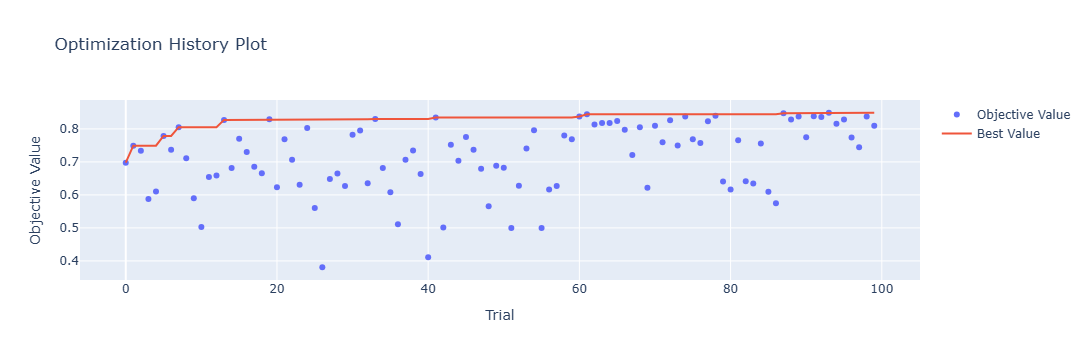

In [24]:
fig2 = optuna.visualization.plot_optimization_history(study)
fig2.write_html("optimization_history_full.html")
fig2.show()

# Best Tuned Hyperparamter on Full Mode

In [25]:
print(study.best_value)
best_params

0.8489569703947942


{'smote_level': 'small',
 'C': 0.003106233859762053,
 'kernel': 'linear',
 'gamma': 'scale',
 'max_iter': 2842}

# FINAL EVALUATION ON TEST (with both thresholds) for the Full Mode

In [29]:
# ==============================================================================
# FINAL EVALUATION ON TEST
# ==============================================================================

# Predict probabilities
y_test_pred_prop_svc = final_pipe_svm.predict_proba(X_test)[:, 1]


# find thresholds
thresholds_svc = {"F1": None, "Balanced_Accuracy": None}
best_f1_svc = 0
best_bal_svc = 0

for t in np.arange(0.1, 0.91, 0.01):
    y_pred_t = (y_test_pred_prop_svc >= t).astype(int)
    f1_t = f1_score(y_test, y_pred_t)
    bal_t = balanced_accuracy_score(y_test, y_pred_t)

    if f1_t > best_f1_svc:
        best_f1_svc = f1_t
        thresholds_svc["F1"] = t
    if bal_t > best_bal_svc:
        best_bal_svc = bal_t
        thresholds_svc["Balanced_Accuracy"] = t

# predictions
y_pred_f1_svc = (y_test_pred_prop_svc >= thresholds_svc["F1"]).astype(int)
y_pred_bal_svc = (y_test_pred_prop_svc >= thresholds_svc["Balanced_Accuracy"]).astype(int)

# metrics dicts
metrics_f1_svc = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_f1_svc),
    "precision": precision_score(y_test, y_pred_f1_svc),
    "recall": recall_score(y_test, y_pred_f1_svc),
    "f1": f1_score(y_test, y_pred_f1_svc),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_svc),
    "geometric_mean": geometric_mean_score(y_test, y_pred_f1_svc),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_f1_svc),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_f1_svc)
}

metrics_bal_svc = {
    "balanced_accuracy": balanced_accuracy_score(y_test, y_pred_bal_svc),
    "precision": precision_score(y_test, y_pred_bal_svc),
    "recall": recall_score(y_test, y_pred_bal_svc),
    "f1": f1_score(y_test, y_pred_bal_svc),
    "roc_auc": roc_auc_score(y_test, y_test_pred_prop_svc),
    "geometric_mean": geometric_mean_score(y_test, y_pred_bal_svc),
    "matthews_corrcoef": matthews_corrcoef(y_test, y_pred_bal_svc),
    "cohen_kappa": cohen_kappa_score(y_test, y_pred_bal_svc)
}

# print SVC results
print("\nFINAL EVALUATION ON TEST SET (SVC)")
print("="*70)

print(f"\nUsing F1 Threshold ({thresholds_svc['F1']:.3f})")
print(f"Balanced Accuracy: {metrics_f1_svc['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_f1_svc['precision']:.4f}")
print(f"Recall: {metrics_f1_svc['recall']:.4f}")
print(f"F1 Score: {metrics_f1_svc['f1']:.4f}")
print(f"ROC-AUC: {metrics_f1_svc['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_f1_svc['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_f1_svc['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_f1_svc['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_f1_svc))
print("\nClassification Report:\n", classification_report(y_test, y_pred_f1_svc))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_f1_svc))

print(f"\nUsing Balanced Accuracy Threshold ({thresholds_svc['Balanced_Accuracy']:.3f})")
print(f"Balanced Accuracy: {metrics_bal_svc['balanced_accuracy']:.4f}")
print(f"Precision: {metrics_bal_svc['precision']:.4f}")
print(f"Recall: {metrics_bal_svc['recall']:.4f}")
print(f"F1 Score: {metrics_bal_svc['f1']:.4f}")
print(f"ROC-AUC: {metrics_bal_svc['roc_auc']:.4f}")
print(f"Geometric Mean: {metrics_bal_svc['geometric_mean']:.4f}")
print(f"Matthews Corr: {metrics_bal_svc['matthews_corrcoef']:.4f}")
print(f"Cohen Kappa: {metrics_bal_svc['cohen_kappa']:.4f}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal_svc))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal_svc))
print("\nImbalanced Report:\n", classification_report_imbalanced(y_test, y_pred_bal_svc))

best_params_svc = study.best_params
best_value_svc = study.best_value
study_svc = study

# Save SVC model dict
model_dict_svc = {
    "best_params": best_params_svc,
    "best_value": best_value_svc,
    "thresholds": thresholds_svc,
    "metrics_f1": metrics_f1_svc,
    "metrics_balanced_accuracy": metrics_bal_svc,
    "study": study_svc,
    "model": final_pipe_svm
}

joblib.dump(model_dict_svc, "SVC_full_model.pkl")


FINAL EVALUATION ON TEST SET (SVC)

Using F1 Threshold (0.100)
Balanced Accuracy: 0.5000
Precision: 0.0329
Recall: 1.0000
F1 Score: 0.0638
ROC-AUC: 0.8378
Geometric Mean: 0.0000
Matthews Corr: 0.0000
Cohen Kappa: 0.0000

Confusion Matrix:
 [[   0 6369]
 [   0  217]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      6369
           1       0.03      1.00      0.06       217

    accuracy                           0.03      6586
   macro avg       0.02      0.50      0.03      6586
weighted avg       0.00      0.03      0.00      6586


Imbalanced Report:
                    pre       rec       spe        f1       geo       iba       sup

          0       0.00      0.00      1.00      0.00      0.00      0.00      6369
          1       0.03      1.00      0.00      0.06      0.00      0.00       217

avg / total       0.00      0.03      0.97      0.00      0.00      0.00      6586


Using Balanced Accuracy

C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\python\Lib\site-packages\sklearn\metrics\_classification.py:1

['SVC_full_model.pkl']

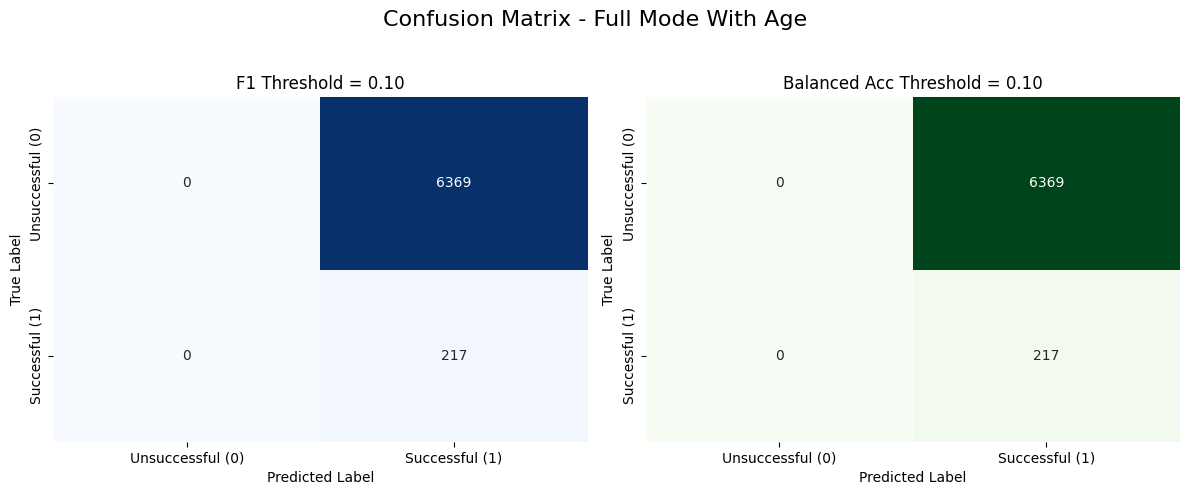

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ==============================================================================
# CONFUSION MATRIX PLOTS SIDE BY SIDE
# ==============================================================================

# Compute confusion matrices
cm_f1 = confusion_matrix(y_test, y_pred_f1_svc)
cm_bal = confusion_matrix(y_test, y_pred_bal_svc)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#  F1 Threshold 
sns.heatmap(cm_f1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[0])
axes[0].set_title(f"F1 Threshold = {thresholds_svc['F1']:.2f}")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

#  Balanced Accuracy Threshold 
sns.heatmap(cm_bal, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Unsuccessful (0)", "Successful (1)"],
            yticklabels=["Unsuccessful (0)", "Successful (1)"],
            ax=axes[1])
axes[1].set_title(f"Balanced Acc Threshold = {thresholds_svc['Balanced_Accuracy']:.2f}")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

# Overall title
plt.suptitle("Confusion Matrix - Full Mode With Age", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.savefig("Confusion Matrix - Full Mode")
plt.show()

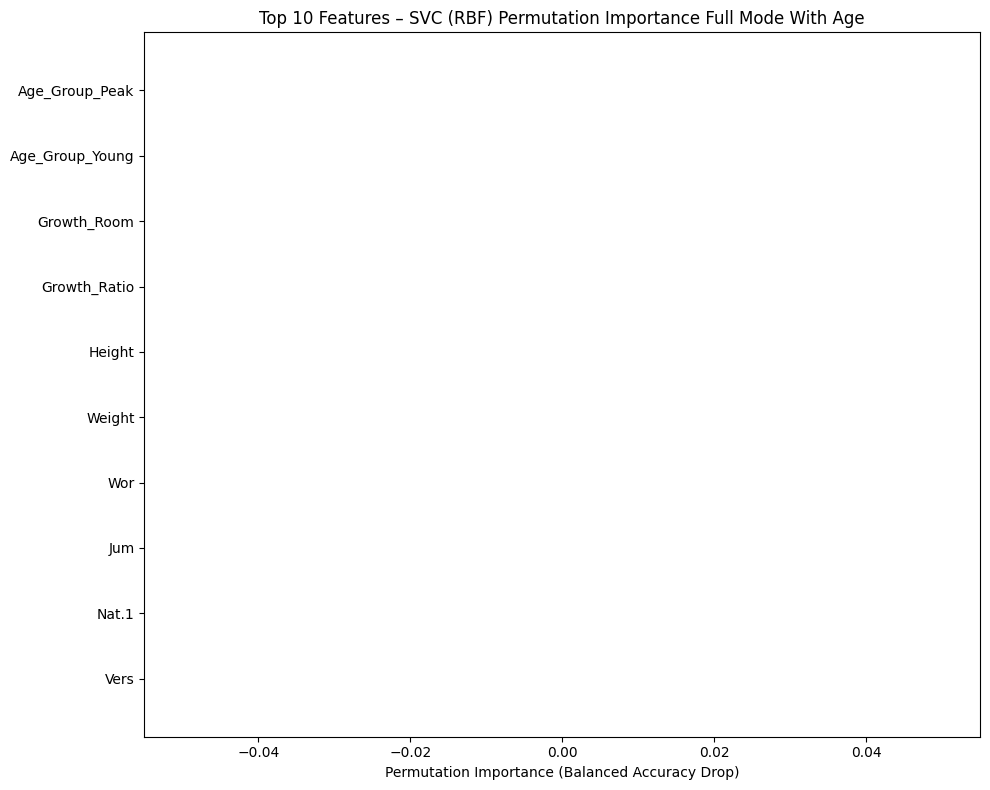

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

result = permutation_importance(
    final_pipe_svm,
    X_test,
    y_test,
    scoring="balanced_accuracy",
    n_repeats=5,
    random_state=SEED,
    n_jobs=-1
)

importances = result.importances_mean
std = result.importances_std
feature_names = np.array(X_test.columns)

# Sort importances
sorted_idx = np.argsort(importances)[::-1]

# Top N features
top_n = 10
top_idx = sorted_idx[:top_n]

# Plot
plt.figure(figsize=(10, 8))
plt.barh(feature_names[top_idx][::-1], importances[top_idx][::-1], xerr=std[top_idx][::-1])
plt.xlabel("Permutation Importance (Balanced Accuracy Drop)")
plt.title("Top 10 Features – SVC (RBF) Permutation Importance Full Mode With Age")
plt.tight_layout()
plt.show()

# visualize the comparison of the models based on different metrics.

In [16]:
!pip install --upgrade pip setuptools wheel
!pip install --upgrade scikit-learn imbalanced-learn optuna joblib matplotlib pandas numpy

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
Using cached wheel-0.45.1-py3-none-any.whl (72 kB)



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\python\python.exe -m pip install --upgrade pip setuptools wheel



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import joblib

# Load the realistic mode model
svc_realistic_model = joblib.load("SVC_realistic_model.pkl")

# Load the full mode model
svc_full_model = joblib.load("SVC_full_model.pkl")

print("Realistic Model Metrics (F1 Optimal Threshold):")
print(svc_realistic_model['metrics_f1'])

print("\nFull Model Metrics (F1 Optimal Threshold):")
print(svc_full_model['metrics_f1'])

print("\nRealistic Model Metrics (Balanced Accuracy Optimal Threshold):")
print(svc_realistic_model['metrics_balanced_accuracy'])

print("\nFull Model Metrics (Balanced Accuracy Optimal Threshold):")
print(svc_full_model['metrics_balanced_accuracy'])

Realistic Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.7442566347797837, 'precision': 0.07769532955041467, 'recall': 0.8202764976958525, 'f1': 0.1419457735247209, 'roc_auc': 0.7832817079850342, 'geometric_mean': np.float64(0.7403640448157585), 'matthews_corrcoef': 0.18308287671049467, 'cohen_kappa': 0.08698626086537531}

Full Model Metrics (F1 Optimal Threshold):
{'balanced_accuracy': 0.5, 'precision': 0.032948679016094745, 'recall': 1.0, 'f1': 0.06379538438924004, 'roc_auc': 0.8377647200979976, 'geometric_mean': np.float64(0.0), 'matthews_corrcoef': 0.0, 'cohen_kappa': 0.0}

Realistic Model Metrics (Balanced Accuracy Optimal Threshold):
{'balanced_accuracy': 0.7442566347797837, 'precision': 0.07769532955041467, 'recall': 0.8202764976958525, 'f1': 0.1419457735247209, 'roc_auc': 0.7832817079850342, 'geometric_mean': np.float64(0.7403640448157585), 'matthews_corrcoef': 0.18308287671049467, 'cohen_kappa': 0.08698626086537531}

Full Model Metrics (Balanced Accuracy Optimal

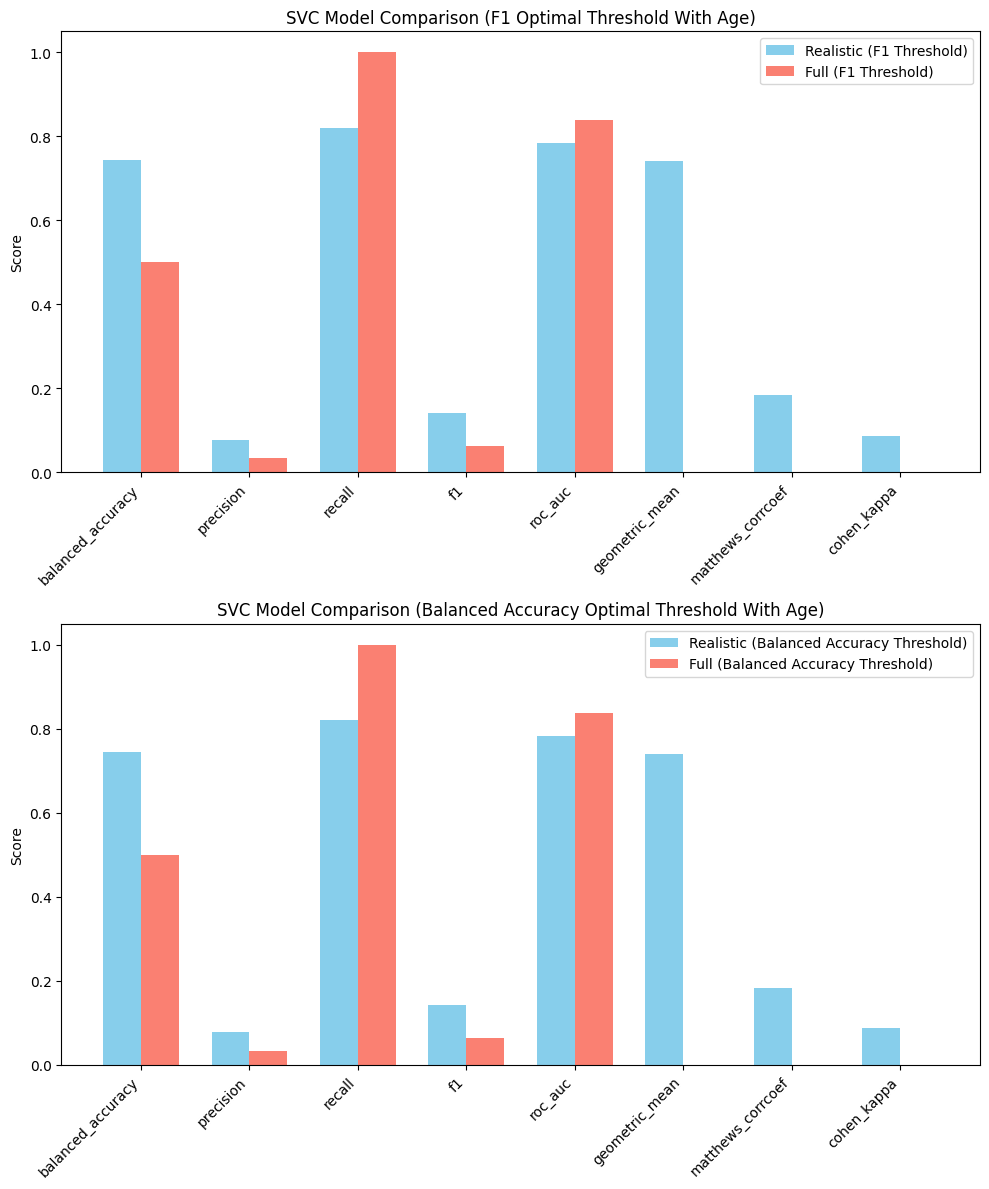

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Extract metrics for comparison
metrics_f1_realistic = svc_realistic_model['metrics_f1']
metrics_f1_full = svc_full_model['metrics_f1']
metrics_bal_realistic = svc_realistic_model['metrics_balanced_accuracy']
metrics_bal_full = svc_full_model['metrics_balanced_accuracy']

# Create DataFrames for easier plotting
df_f1 = pd.DataFrame({
    "Metric": metrics_f1_realistic.keys(),
    "Realistic (F1 Threshold)": metrics_f1_realistic.values(),
    "Full (F1 Threshold)": metrics_f1_full.values()
})

df_bal = pd.DataFrame({
    "Metric": metrics_bal_realistic.keys(),
    "Realistic (Balanced Accuracy Threshold)": metrics_bal_realistic.values(),
    "Full (Balanced Accuracy Threshold)": metrics_bal_full.values()
})

# Create a 2x1 grid of plots
fig, axes = plt.subplots(2, 1, figsize=(10, 12)) 

# Plotting F1-optimal threshold metrics in the first subplot
bar_width = 0.35
x_f1 = np.arange(len(df_f1["Metric"]))

rects1_f1 = axes[0].bar(x_f1 - bar_width/2, df_f1["Realistic (F1 Threshold)"], bar_width, label='Realistic (F1 Threshold)', color='skyblue')
rects2_f1 = axes[0].bar(x_f1 + bar_width/2, df_f1["Full (F1 Threshold)"], bar_width, label='Full (F1 Threshold)', color='salmon')

axes[0].set_ylabel("Score")
axes[0].set_title("SVC Model Comparison (F1 Optimal Threshold With Age)") 
axes[0].set_xticks(x_f1)
axes[0].set_xticklabels(df_f1["Metric"], rotation=45, ha='right')
axes[0].legend()

bar_width = 0.35
x_bal = np.arange(len(df_bal["Metric"]))

rects1_bal = axes[1].bar(x_bal - bar_width/2, df_bal["Realistic (Balanced Accuracy Threshold)"], bar_width, label='Realistic (Balanced Accuracy Threshold)', color='skyblue')
rects2_bal = axes[1].bar(x_bal + bar_width/2, df_bal["Full (Balanced Accuracy Threshold)"], bar_width, label='Full (Balanced Accuracy Threshold)', color='salmon')

axes[1].set_ylabel("Score")
axes[1].set_title("SVC Model Comparison (Balanced Accuracy Optimal Threshold With Age)") 
axes[1].set_xticks(x_bal)
axes[1].set_xticklabels(df_bal["Metric"], rotation=45, ha='right')
axes[1].legend()

plt.tight_layout()
plt.savefig("svc_model_comparison_2x1_grid.png") 
plt.show()

SVC models loaded successfully.
Reading file...
Dataset: 43,903 rows, 82 cols
Success rate: 3.29%
MODE=full -> Keeping CA and PA

Features: 69  |  Samples: 43,903
Success distribution: {0: 42460, 1: 1443}


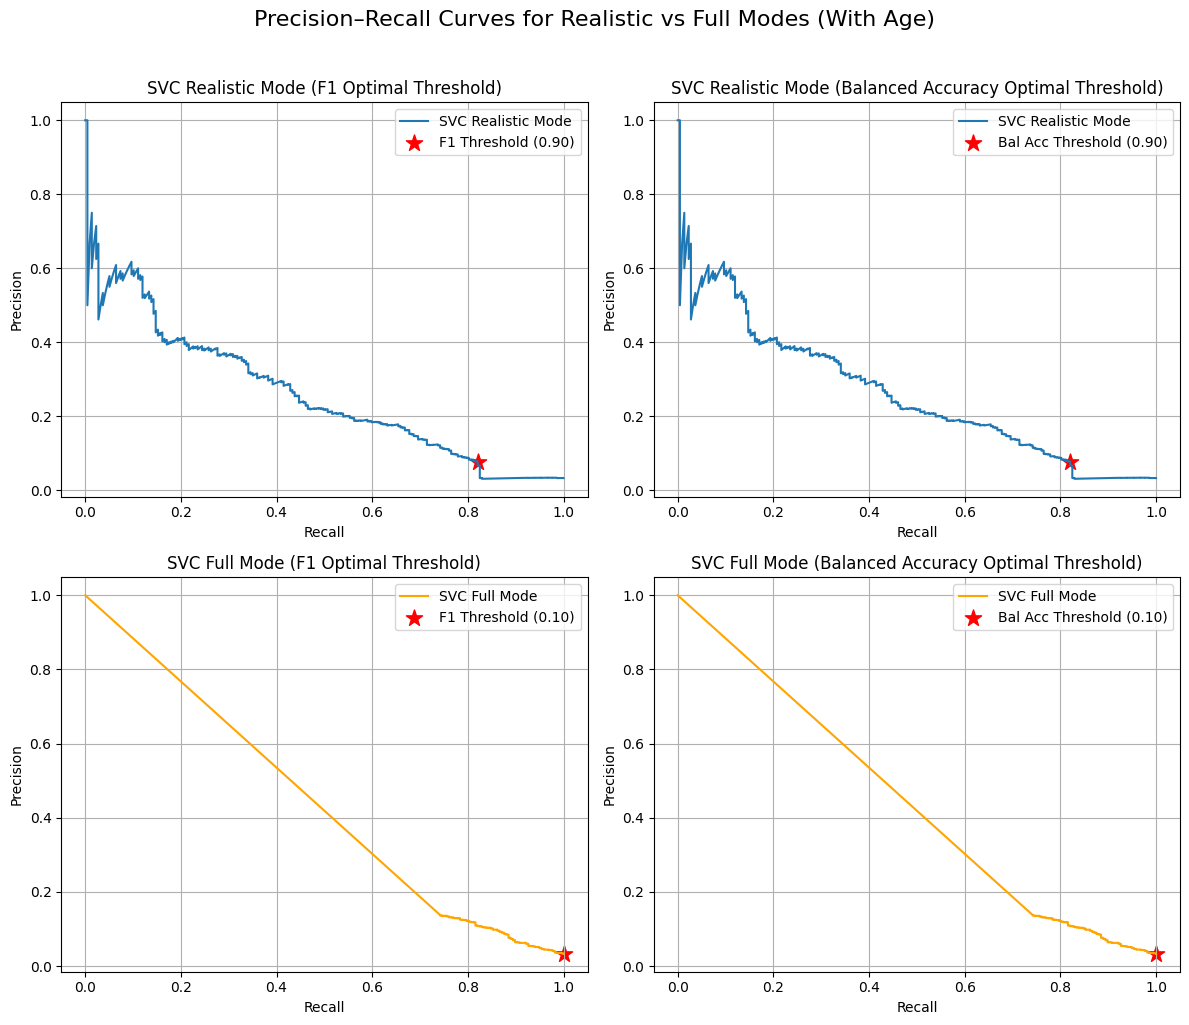

In [34]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import joblib 

# ==============================================================================
# CONFIGURATION
# ==============================================================================
SEED = 67
TEST_SIZE = 0.15
VAL_SIZE = 0.15
FILE_PATH = "C:/Users/Ebrah/OneDrive/Desktop/Ebrahim-UOB/STAT499 - Senior Project/Code/work here/final_dataset_p90_success.xlsx"

# ==============================================================================
# Load SVC Models
# ==============================================================================
try:
    svc_realistic_model = joblib.load("SVC_realistic_model.pkl")
    svc_full_model = joblib.load("SVC_full_model.pkl")
    print("SVC models loaded successfully.")
except FileNotFoundError:
    print("Model files (SVC_realistic_model.pkl or SVC_full_model.pkl) not found. Plotting will fail.")


# ==============================================================================
# Load and transform data
# ==============================================================================
print("Reading file...")
df = pd.read_excel(FILE_PATH)
print(f"Dataset: {df.shape[0]:,} rows, {df.shape[1]} cols")
print(f"Success rate: {df['success_label'].mean()*100:.2f}%")


# drop irrelevant/leak columns
drop_cols = [
    'UID', 'Name', 'Club', 'Source_File',
    'UID_k1', 'UID_k2', 'UID_k3',
    'Transfer Value_k1', 'Transfer Value_k2', 'Transfer Value_k3',
    'success_k1', 'success_k2', 'success_k3',
    'Transfer Value',
    'Position', 'Nat',
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

MODE = "full" 
if MODE == "realistic":
    df = df.drop(columns=[c for c in ["CA", "PA"] if c in df.columns], errors='ignore')
    print("MODE=realistic -> Dropped CA and PA")
else:
    print("MODE=full -> Keeping CA and PA")

# feature engineering (if full mode)
if all(col in df.columns for col in ["PA", "CA"]):
    df["Growth_Ratio"] = df["PA"] / df["CA"].replace(0, 1)
    df["Growth_Room"] = df["PA"] - df["CA"]

if 'Age' in df.columns:
    df['Age_Group_Young'] = (df['Age'] <= 20).astype(int)
    df['Age_Group_Peak'] = ((df['Age'] > 20) & (df['Age'] <= 23)).astype(int)

X = df.drop(columns=["success_label"])
y = df["success_label"]
print(f"\nFeatures: {X.shape[1]}  |  Samples: {X.shape[0]:,}")
print(f"Success distribution: {y.value_counts().to_dict()}")

# Split Train / Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=VAL_SIZE + TEST_SIZE, stratify=y, random_state=SEED)
# Split Validation / Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

# Separate X_test for realistic and full models
X_test_realistic = X_test.drop(columns=[c for c in ["CA", "PA", "Growth_Ratio", "Growth_Room"] if c in X_test.columns], errors='ignore')
X_test_full = X_test.copy()


# ==============================================================================
# Plotting Precision-Recall Curves (2x2 Grid) - MODIFIED FOR SVC
# ==============================================================================

# Get predicted probabilities for the test set for both models
y_test_pred_prop_realistic = svc_realistic_model['model'].predict_proba(X_test_realistic)[:, 1]
y_test_pred_prop_full = svc_full_model['model'].predict_proba(X_test_full)[:, 1]

# Calculate precision and recall for different thresholds for realistic model
precision_realistic, recall_realistic, thresholds_realistic = precision_recall_curve(y_test, y_test_pred_prop_realistic)

# Calculate precision and recall for different thresholds for full model
precision_full, recall_full, thresholds_full = precision_recall_curve(y_test, y_test_pred_prop_full)

# Get the optimal thresholds from the loaded models
f1_threshold_realistic = svc_realistic_model['thresholds']['F1']
bal_acc_threshold_realistic = svc_realistic_model['thresholds']['Balanced_Accuracy']
f1_threshold_full = svc_full_model['thresholds']['F1']
bal_acc_threshold_full = svc_full_model['thresholds']['Balanced_Accuracy']

# Find the precision and recall values at the optimal thresholds
f1_idx_realistic = np.argmax(thresholds_realistic >= f1_threshold_realistic) if np.any(thresholds_realistic >= f1_threshold_realistic) else len(thresholds_realistic) - 1
f1_precision_realistic = precision_realistic[f1_idx_realistic]
f1_recall_realistic = recall_realistic[f1_idx_realistic]

bal_acc_idx_realistic = np.argmax(thresholds_realistic >= bal_acc_threshold_realistic) if np.any(thresholds_realistic >= bal_acc_threshold_realistic) else len(thresholds_realistic) - 1
bal_acc_precision_realistic = precision_realistic[bal_acc_idx_realistic]
bal_acc_recall_realistic = recall_realistic[bal_acc_idx_realistic]

f1_idx_full = np.argmax(thresholds_full >= f1_threshold_full) if np.any(thresholds_full >= f1_threshold_full) else len(thresholds_full) - 1
f1_precision_full = precision_full[f1_idx_full]
f1_recall_full = recall_full[f1_idx_full]

bal_acc_idx_full = np.argmax(thresholds_full >= bal_acc_threshold_full) if np.any(thresholds_full >= bal_acc_threshold_full) else len(thresholds_full) - 1
bal_acc_precision_full = precision_full[bal_acc_idx_full]
bal_acc_recall_full = recall_full[bal_acc_idx_full]


# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot Realistic Mode (F1 Threshold)
axes[0, 0].plot(recall_realistic, precision_realistic, label='SVC Realistic Mode', linestyle='-') 
axes[0, 0].scatter(f1_recall_realistic, f1_precision_realistic, color='red', marker='*', s=150,
                   label=f'F1 Threshold ({f1_threshold_realistic:.2f})')
axes[0, 0].set_xlabel("Recall")
axes[0, 0].set_ylabel("Precision")
axes[0, 0].set_title("SVC Realistic Mode (F1 Optimal Threshold)")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot Realistic Mode (Balanced Accuracy Threshold)
axes[0, 1].plot(recall_realistic, precision_realistic, label='SVC Realistic Mode', linestyle='-')  
axes[0, 1].scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='red', marker='*', s=150,
                   label=f'Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')
axes[0, 1].set_xlabel("Recall")
axes[0, 1].set_ylabel("Precision")
axes[0, 1].set_title("SVC Realistic Mode (Balanced Accuracy Optimal Threshold)") 
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot Full Mode (F1 Threshold)
axes[1, 0].plot(recall_full, precision_full, label='SVC Full Mode', color='orange', linestyle='-')  
axes[1, 0].scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
                   label=f'F1 Threshold ({f1_threshold_full:.2f})')
axes[1, 0].set_xlabel("Recall")
axes[1, 0].set_ylabel("Precision")
axes[1, 0].set_title("SVC Full Mode (F1 Optimal Threshold)") 
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot Full Mode (Balanced Accuracy Threshold)
axes[1, 1].plot(recall_full, precision_full, label='SVC Full Mode', color='orange', linestyle='-')  
axes[1, 1].scatter(bal_acc_recall_full, bal_acc_precision_full, color='red', marker='*', s=150,
                   label=f'Bal Acc Threshold ({bal_acc_threshold_full:.2f})')
axes[1, 1].set_xlabel("Recall")
axes[1, 1].set_ylabel("Precision")
axes[1, 1].set_title("SVC Full Mode (Balanced Accuracy Optimal Threshold)") 
axes[1, 1].legend()
axes[1, 1].grid(True)

fig.suptitle(
    "Precision–Recall Curves for Realistic vs Full Modes (With Age)",
    fontsize=16,
    y=1.02
)
plt.tight_layout()
plt.savefig("svc_precision_recall_4grid.png")  
plt.show()

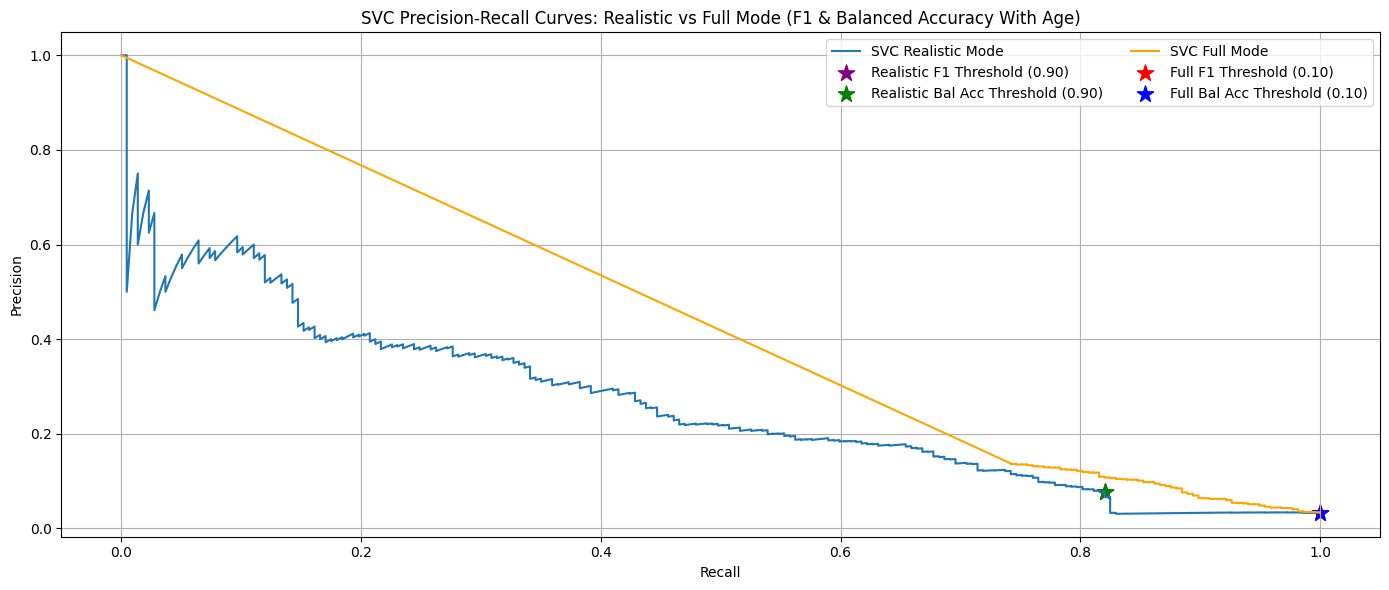

In [35]:
plt.figure(figsize=(14, 6))

#  SVC Realistic Mode 
plt.plot(recall_realistic, precision_realistic, label='SVC Realistic Mode', linestyle='-') 
plt.scatter(f1_recall_realistic, f1_precision_realistic, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({f1_threshold_realistic:.2f})')
plt.scatter(bal_acc_recall_realistic, bal_acc_precision_realistic, color='green', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({bal_acc_threshold_realistic:.2f})')

#  SVC Full Mode 
plt.plot(recall_full, precision_full, label='SVC Full Mode', color='orange', linestyle='-') 
plt.scatter(f1_recall_full, f1_precision_full, color='red', marker='*', s=150,
            label=f'Full F1 Threshold ({f1_threshold_full:.2f})')
plt.scatter(bal_acc_recall_full, bal_acc_precision_full, color='blue', marker='*', s=150,
            label=f'Full Bal Acc Threshold ({bal_acc_threshold_full:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("SVC Precision-Recall Curves: Realistic vs Full Mode (F1 & Balanced Accuracy With Age)") 
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("svc_precision_recall_combined.png") 
plt.show()

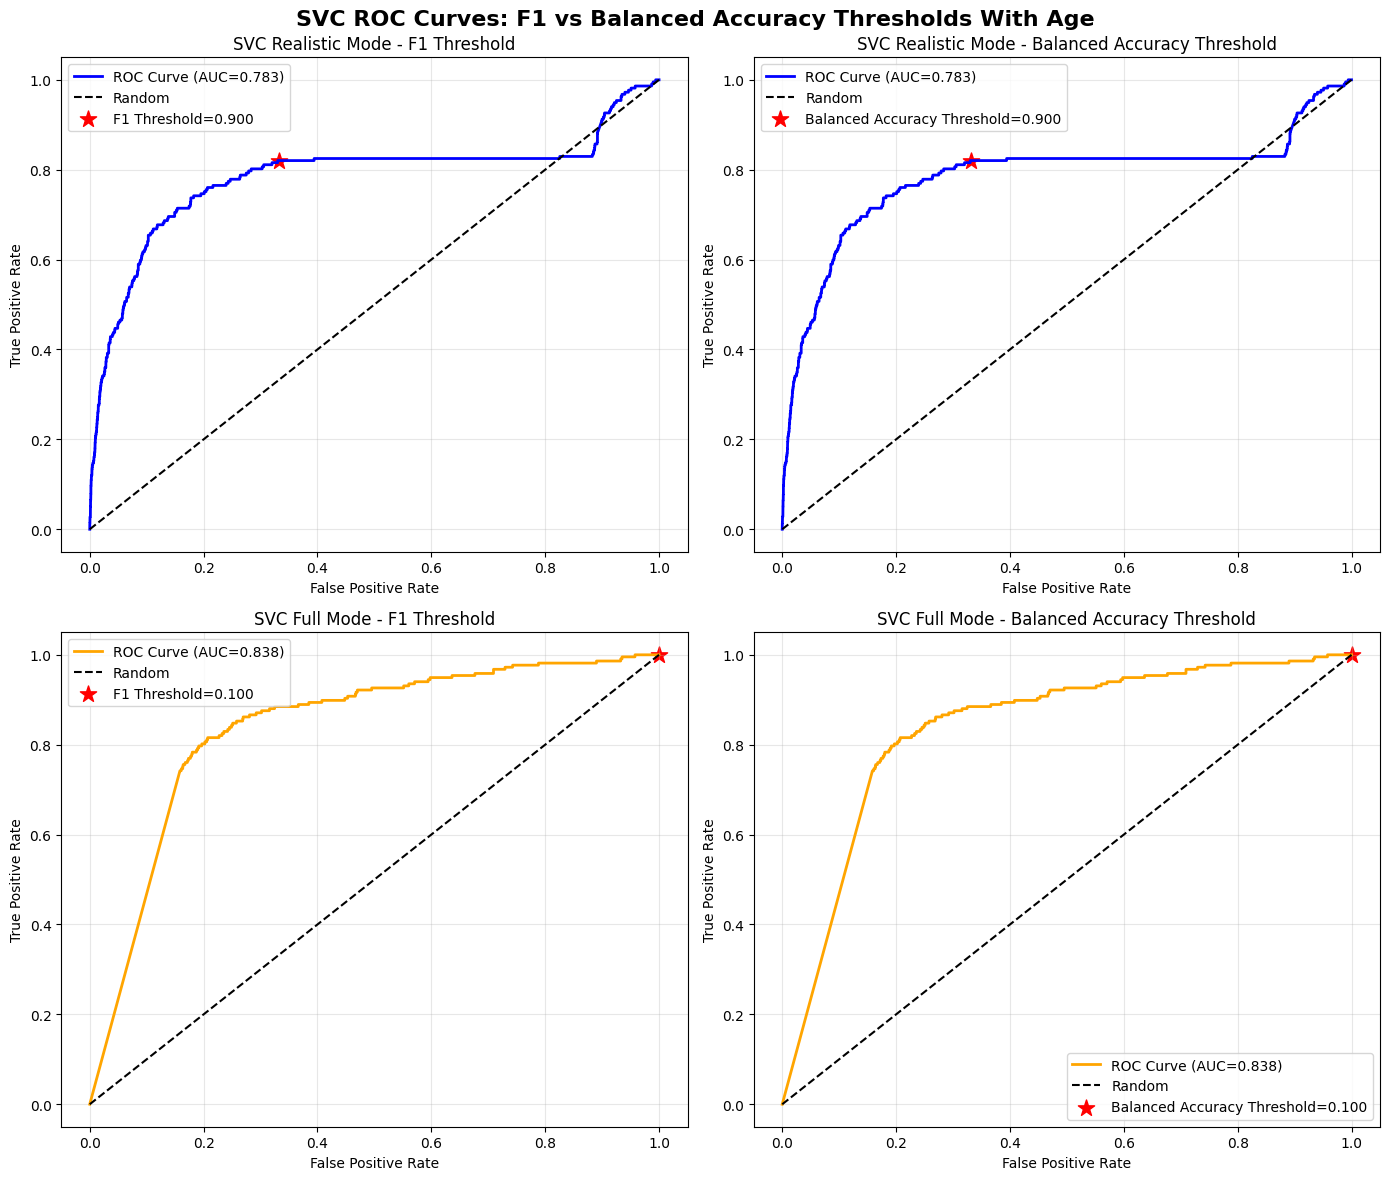

In [36]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Helper function to compute FPR/TPR for a threshold
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = (cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return fpr, tpr

# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('SVC ROC Curves: F1 vs Balanced Accuracy Thresholds With Age', fontsize=16, fontweight='bold') # Updated Title

# -----------------------------
# SVC Realistic Mode
# -----------------------------
# Assuming y_test_pred_prop_realistic is calculated using svc_realistic_model
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
roc_auc_real = auc(fpr_real, tpr_real)

# F1 Threshold
fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, svc_realistic_model['thresholds']['F1'])
axes[0, 0].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 0].scatter(fpr_f1_real, tpr_f1_real, color='red', s=150, marker='*',
                   label=f'F1 Threshold={svc_realistic_model["thresholds"]["F1"]:.3f}')
axes[0, 0].set_title('SVC Realistic Mode - F1 Threshold') # Updated Title
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(loc='best')

# Balanced Accuracy Threshold
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, svc_realistic_model['thresholds']['Balanced_Accuracy'])
axes[0, 1].plot(fpr_real, tpr_real, 'b-', linewidth=2, label=f'ROC Curve (AUC={roc_auc_real:.3f})')
axes[0, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[0, 1].scatter(fpr_bal_real, tpr_bal_real, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={svc_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}') 
axes[0, 1].set_title('SVC Realistic Mode - Balanced Accuracy Threshold') 
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(loc='best')

# -----------------------------
# SVC Full Mode
# -----------------------------
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)
roc_auc_full = auc(fpr_full, tpr_full)

# F1 Threshold
fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, svc_full_model['thresholds']['F1'])
axes[1, 0].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 0].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 0].scatter(fpr_f1_full, tpr_f1_full, color='red', s=150, marker='*',
                   label=f'F1 Threshold={svc_full_model["thresholds"]["F1"]:.3f}')
axes[1, 0].set_title('SVC Full Mode - F1 Threshold') 
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(loc='best')

# Balanced Accuracy Threshold
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, svc_full_model['thresholds']['Balanced_Accuracy'])
axes[1, 1].plot(fpr_full, tpr_full, 'orange', linewidth=2, label=f'ROC Curve (AUC={roc_auc_full:.3f})')
axes[1, 1].plot([0,1], [0,1], 'k--', label='Random')
axes[1, 1].scatter(fpr_bal_full, tpr_bal_full, color='red', s=150, marker='*',
                   label=f'Balanced Accuracy Threshold={svc_full_model["thresholds"]["Balanced_Accuracy"]:.3f}') 
axes[1, 1].set_title('SVC Full Mode - Balanced Accuracy Threshold') # Updated Title
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(loc='best')

plt.tight_layout()
plt.savefig("svc_roc_2x2_grid.png", dpi=300, bbox_inches='tight') 
plt.show()

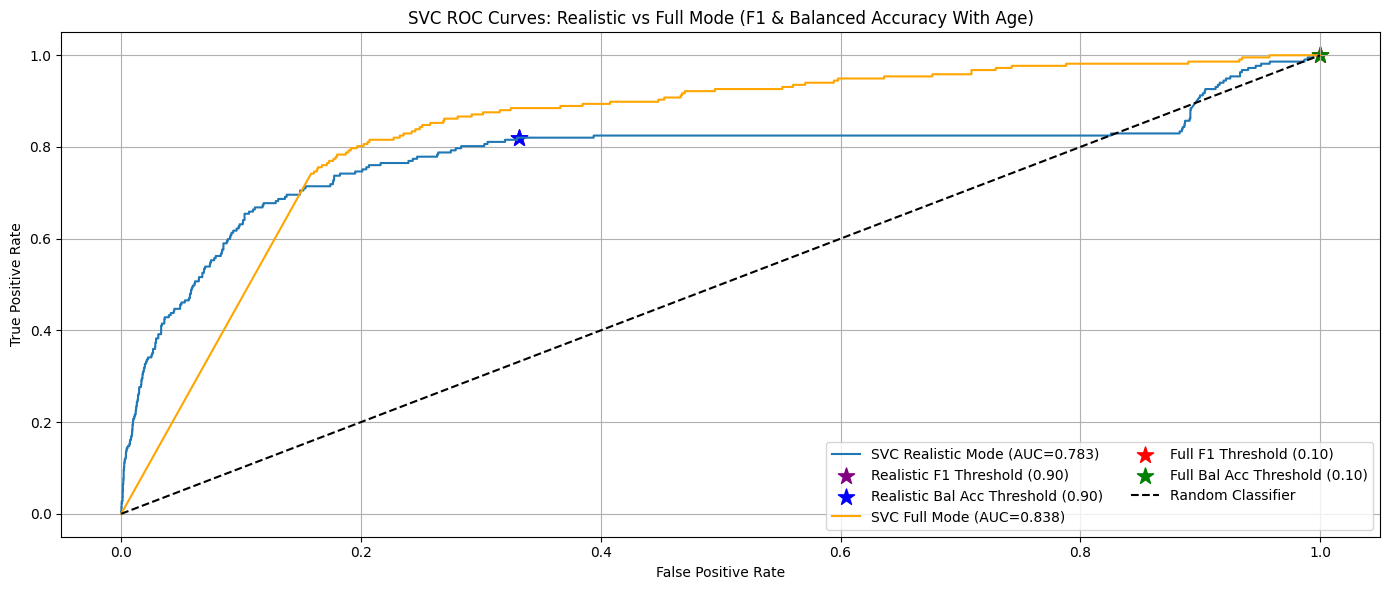

In [37]:
import matplotlib.pyplot as plt

# Compute ROC curves
fpr_real, tpr_real, _ = roc_curve(y_test, y_test_pred_prop_realistic)
fpr_full, tpr_full, _ = roc_curve(y_test, y_test_pred_prop_full)

roc_auc_real = auc(fpr_real, tpr_real)
roc_auc_full = auc(fpr_full, tpr_full)

# Compute points for thresholds
def roc_point(y_true, y_pred_prop, threshold):
    y_pred = (y_pred_prop >= threshold).astype(int)
    # Using a try-except to safely access confusion matrix components
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except ValueError:
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = (cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1])

    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return fpr, tpr

# Updated to use svc_realistic_model
fpr_f1_real, tpr_f1_real = roc_point(y_test, y_test_pred_prop_realistic, svc_realistic_model['thresholds']['F1'])
fpr_bal_real, tpr_bal_real = roc_point(y_test, y_test_pred_prop_realistic, svc_realistic_model['thresholds']['Balanced_Accuracy'])

# Updated to use svc_full_model
fpr_f1_full, tpr_f1_full = roc_point(y_test, y_test_pred_prop_full, svc_full_model['thresholds']['F1'])
fpr_bal_full, tpr_bal_full = roc_point(y_test, y_test_pred_prop_full, svc_full_model['thresholds']['Balanced_Accuracy'])

# Plot combined ROC
plt.figure(figsize=(14, 6))

#  SVC Realistic Mode 
plt.plot(fpr_real, tpr_real, label=f'SVC Realistic Mode (AUC={roc_auc_real:.3f})', linestyle='-') 
plt.scatter(fpr_f1_real, tpr_f1_real, color='purple', marker='*', s=150,
            label=f'Realistic F1 Threshold ({svc_realistic_model["thresholds"]["F1"]:.2f})') 
plt.scatter(fpr_bal_real, tpr_bal_real, color='blue', marker='*', s=150,
            label=f'Realistic Bal Acc Threshold ({svc_realistic_model["thresholds"]["Balanced_Accuracy"]:.2f})') 

#  SVC Full Mode 
plt.plot(fpr_full, tpr_full, label=f'SVC Full Mode (AUC={roc_auc_full:.3f})', color='orange', linestyle='-')
plt.scatter(fpr_f1_full, tpr_f1_full, color='red', marker='*', s=150, 
            label=f'Full F1 Threshold ({svc_full_model["thresholds"]["F1"]:.2f})') 
plt.scatter(fpr_bal_full, tpr_bal_full, color='green', marker='*', s=150, 
            label=f'Full Bal Acc Threshold ({svc_full_model["thresholds"]["Balanced_Accuracy"]:.2f})') 

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVC ROC Curves: Realistic vs Full Mode (F1 & Balanced Accuracy With Age)")  
plt.legend(ncol=2)
plt.grid(True)
plt.tight_layout()
plt.savefig("svc_roc_combined.png", dpi=300)
plt.show()

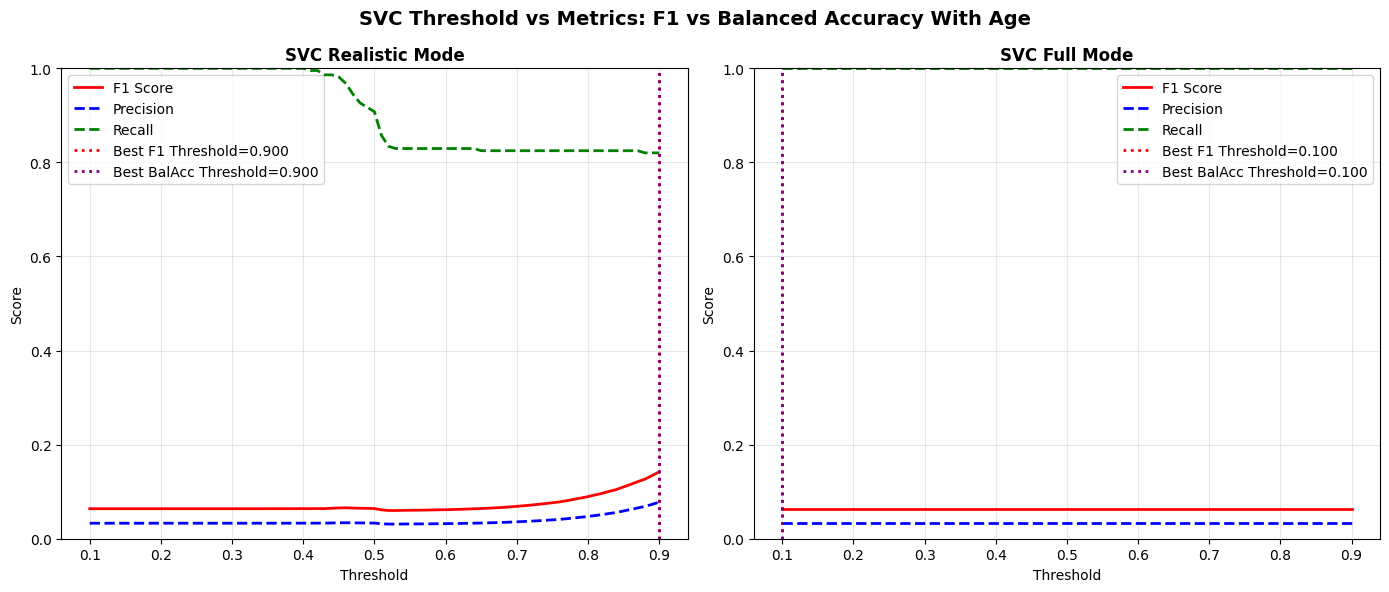

In [38]:
from sklearn.metrics import f1_score, balanced_accuracy_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt

# Define threshold range
threshold_range = np.arange(0.1, 0.91, 0.01)

def compute_metrics(y_true, y_pred_prop, threshold_range):
    f1_scores, bal_acc_scores, precision_scores, recall_scores = [], [], [], []
    for t in threshold_range:
        y_pred_t = (y_pred_prop >= t).astype(int)
        # Set zero_division=0 to handle cases with no positive predictions
        f1_scores.append(f1_score(y_true, y_pred_t, zero_division=0))
        bal_acc_scores.append(balanced_accuracy_score(y_true, y_pred_t))
        precision_scores.append(precision_score(y_true, y_pred_t, zero_division=0))
        recall_scores.append(recall_score(y_true, y_pred_t, zero_division=0))
    return f1_scores, bal_acc_scores, precision_scores, recall_scores

#  Realistic Mode (Using SVC predictions) 
f1_scores_real, bal_acc_scores_real, precision_scores_real, recall_scores_real = compute_metrics(
    y_test, y_test_pred_prop_realistic, threshold_range
)

#  Full Mode (Using SVC predictions) 
f1_scores_full, bal_acc_scores_full, precision_scores_full, recall_scores_full = compute_metrics(
    y_test, y_test_pred_prop_full, threshold_range
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('SVC Threshold vs Metrics: F1 vs Balanced Accuracy With Age', fontsize=14, fontweight='bold') # Updated Title

#  SVC Realistic Mode 
axes[0].plot(threshold_range, f1_scores_real, 'r-', linewidth=2, label='F1 Score')
axes[0].plot(threshold_range, precision_scores_real, 'b--', linewidth=2, label='Precision')
axes[0].plot(threshold_range, recall_scores_real, 'g--', linewidth=2, label='Recall')
axes[0].axvline(svc_realistic_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2, 
                 label=f'Best F1 Threshold={svc_realistic_model["thresholds"]["F1"]:.3f}')
axes[0].axvline(svc_realistic_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2, 
                 label=f'Best BalAcc Threshold={svc_realistic_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[0].set_title('SVC Realistic Mode', fontsize=12, fontweight='bold') # Updated Title
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='best')
axes[0].set_ylim([0, 1])

#  SVC Full Mode 
axes[1].plot(threshold_range, f1_scores_full, 'r-', linewidth=2, label='F1 Score')
axes[1].plot(threshold_range, precision_scores_full, 'b--', linewidth=2, label='Precision')
axes[1].plot(threshold_range, recall_scores_full, 'g--', linewidth=2, label='Recall')
axes[1].axvline(svc_full_model['thresholds']['F1'], color='red', linestyle=':', linewidth=2,  
                 label=f'Best F1 Threshold={svc_full_model["thresholds"]["F1"]:.3f}')
axes[1].axvline(svc_full_model['thresholds']['Balanced_Accuracy'], color='purple', linestyle=':', linewidth=2,  
                 label=f'Best BalAcc Threshold={svc_full_model["thresholds"]["Balanced_Accuracy"]:.3f}')
axes[1].set_title('SVC Full Mode', fontsize=12, fontweight='bold')  
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='best')
axes[1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig("svc_threshold_vs_metrics_pair_combined.png", dpi=300, bbox_inches='tight') 
plt.show()